# 1. Exploration des données et prétraitement





## 0. Initialisation de l’environnement Spark

**Objectif :** Mettre en place un environnement distribué adapté au traitement de données massives via PySpark, en préparation des étapes d'exploration et de modélisation.



#### Chargement des bibliothèques


In [1]:
# Importation des bibliothèques principales
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, round as spark_round

from pyspark.ml.stat import *
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import  VectorAssembler , RobustScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator ,MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#  Visualisation et analyse complémentaire

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from builtins import round


####  Création de la session Spark

In [ ]:
# Création de la session Spark

spark = SparkSession.builder \
    .appName("DetectionFraude") \
    .master("local[8]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate() 


spark 

Spark est maintenant opérationnel. La session est configurée en mode local avec tous les cœurs CPU disponibles (local[*]), ce qui est suffisant pour traiter efficacement les volumes de données importants du projet IEEE.

In [3]:
# fonciton nettoyage de mémoire 
def cleanup(*vars_to_del):
    for var in vars_to_del:
        del var
    import gc; gc.collect()
    spark.catalog.clearCache()

## 1. Chargement et fusion des données

###  Description des données

Le jeu de données est constitué de deux fichiers complémentaires :

####  `train_transaction.csv` — Transactions financières

Contient les données principales liées à chaque opération bancaire :
- `TransactionID` : identifiant unique de la transaction.
- `isFraud` : cible binaire (1 = fraude, 0 = normal).
- `TransactionAmt` : montant de la transaction.
- `ProductCD` : type de produit acheté.
- `card1` à `card6` : identifiants partiels de carte bancaire.
- `addr1`, `addr2` : zones géographiques.
- `dist1`, `dist2` : proximités géographiques.
- `P_emaildomain`, `R_emaildomain` : domaines email.
- `C1` à `C14` : agrégats comportementaux.
- `D1` à `D15` : deltas temporels (liés à la récence).
- `M1` à `M9` : indicateurs binaires (matchs device/adresse...).
- `V1` à `V339` : variables anonymisées dérivées internes.

####  `train_identity.csv` — Identité des utilisateurs

Contient des métadonnées liées aux appareils et aux profils :
- `id_01` à `id_38` : scores d'identité divers.
- `DeviceType`, `DeviceInfo` : type d’appareil.
- `id_30`, `id_31` : système d’exploitation, navigateur.


###  Chargement des données avec PySpark

In [4]:
#  Chargement des datasets

df_transaction = spark.read.csv("../data/train_transaction.csv",header=True , inferSchema=True)

df_identity = spark.read.csv("../data/train_identity.csv" ,header=True , inferSchema=True)

# Dimension datasets 

print(f"Lignes transaction : {df_transaction.count()}, Colonnes transaction : {len(df_transaction.columns)}")
print(f"Lignes identity    : {df_identity.count()}, Colonnes identity    : {len(df_identity.columns)}")


# Vérif des colonnes communes pour la jointure

colonnes_communes = set(df_transaction.columns).intersection(set(df_identity.columns))

print(f"Clés communes : {colonnes_communes}")


Lignes transaction : 590540, Colonnes transaction : 394
Lignes identity    : 144233, Colonnes identity    : 41
Clés communes : {'TransactionID'}


###  Fusion des jeux de données

#### Objectif :
Associer les données d’identité aux transactions, sans exclure celles qui n’en ont pas. Cela permet de garder un volume complet et de marquer la présence ou non d’identité.

####  Détails techniques :
- Jointure effectuée sur `TransactionID`
- Type de jointure : `LEFT JOIN`
- Dataset principal : `df_transaction`
- Dataset secondaire : `df_identity`

In [5]:
# Fusion des deux fichier train  

df = df_transaction.join(df_identity,on="TransactionID", how="left")

print(f"nb de ligne : {df.count()} et de  colonne : {len(df.columns)}")


nb de ligne : 590540 et de  colonne : 434


###  Synthèse post-fusion des données

Sur les **590 540 transactions**, seulement **144 233** ont des informations d'identité dans le fichier `identity.csv`

Cela signifie que plus 446 000 des transactions sont totalement anonymes dans les colonnes comme `DeviceType`, `id_01`, `id_30`, etc.

Cette absence d’identité n’est pas une erreur, mais un signal potentiellement révélateur. Un fraudeur pourrait chercher à éviter d’être traçable en ne fournissant pas d’identifiants techniques.


## 2. Exploration rapide des données (EDA brute)

### Objectif de cette section : Analyse exploratoire rapide (inspection générale)

Cette étape vise à obtenir une première vue d'ensemble du dataset fusionné, afin de :

1. Examiner la variable cible `isFraud` et valider l’hypothèse d’un fort déséquilibre
2. Confirmer la structure générale après fusion (types, format)
3. Étudier la structure identitaire via la variable `has_identity`
4. Explorer quelques statistiques descriptives clés pour orienter l’analyse

 Cette phase permet de valider les hypothèses initiales et de préparer les prochaines étapes : détection d’anomalies, EDA approfondie, puis modélisation.

### 2.1. Analyse de la variable cible `isFraud`

In [6]:
total = df.count()

# Distribution avec pourcentage
df.groupBy("isFraud") \
  .count() \
  .withColumn("perc_%", spark_round(col("count") / total * 100, 2)) \
  .orderBy("isFraud") \
  .show()
  

+-------+------+------+
|isFraud| count|perc_%|
+-------+------+------+
|      0|569877|  96.5|
|      1| 20663|   3.5|
+-------+------+------+



###  Visualisation de la variable cible isFraud

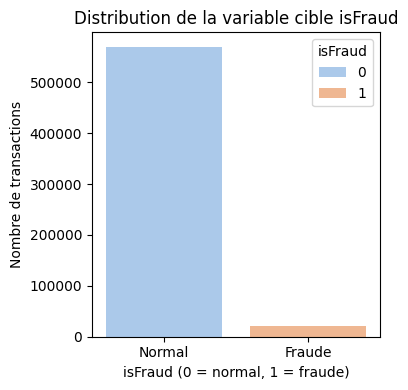

In [ ]:
# Visualisation de la variable cible
fraude_simple = df.groupBy("isFraud").count().toPandas()
fraude_simple.columns = ["isFraud", "count"]

plt.figure(figsize=(4, 4))
sns.barplot(data=fraude_simple, x="isFraud" ,  y="count",hue="isFraud", palette="pastel")

plt.title("Distribution de la variable cible isFraud")
plt.xlabel("isFraud (0 = normal, 1 = fraude)")
plt.ylabel("Nombre de transactions")
plt.xticks([0, 1], ["Normal", "Fraude"])
plt.tight_layout()
plt.show()

# Libere la mémoire de la variable df
cleanup(fraude_simple)

###  Interprétation

L’analyse de la variable cible `isFraud` confirme un **fort déséquilibre de classes** :

- **96,5 %** des transactions sont **non frauduleuses**
- Seulement **3,5 %** sont **frauduleuses**

 Cette distribution est typique des **problèmes de détection de fraude**, où le signal (fraude) est **rare** comparé au bruit (transactions normales).

 Ce déséquilibre aura un **impact direct sur la modélisation** :
- Il rend les métriques classiques comme la précision ou l'exactitude peu fiables
- Il nécessitera l’utilisation de **métriques adaptées** (ex. : F1-score, AUC-ROC, PR Curve)
- Il faudra peut-être recourir à des techniques comme le **rebalancing** (undersampling, oversampling, SMOTE, etc.)

Cette étape valide donc l'une des **hypothèses critiques** posées en amont du projet.

### 2.2 Structure du dataset fusionné


In [9]:
df.select("TransactionID", "DeviceType", "id_01", "id_30", "isFraud" ).show(5)

+-------------+----------+-----+-----------+-------+
|TransactionID|DeviceType|id_01|      id_30|isFraud|
+-------------+----------+-----+-----------+-------+
|      2987000|      NULL| NULL|       NULL|      0|
|      2987001|      NULL| NULL|       NULL|      0|
|      2987002|      NULL| NULL|       NULL|      0|
|      2987003|      NULL| NULL|       NULL|      0|
|      2987004|    mobile|  0.0|Android 7.0|      0|
+-------------+----------+-----+-----------+-------+
only showing top 5 rows



###  Interprétation

L’ensemble des colonnes est bien interprété par Spark :
- Types numériques (`double`), chaînes (`string`) et entiers (`integer`) correctement détectés
- Toutes les colonnes sont `nullable`, laissant entrevoir une forte proportion de valeurs manquantes
- Les colonnes issues d’`identity.csv` (`DeviceType`, `id_01`, etc.) apparaissent en `NULL` pour de nombreuses transactions

Cette observation valide le comportement de la jointure `LEFT` : toutes les transactions sont présentes, mais seules certaines sont enrichies par des données d’identité.

 Nous allons créer une variable binaire `has_identity` afin de capturer cette distinction et d’analyser son lien potentiel avec la fraude.


### 2.3 Étude de la variable `has_identity`

Cette variable binaire a été créée pour indiquer si une transaction dispose ou non d'informations identitaires issues du fichier `identity.csv` :

- 1 si au moins une information d’identité (ex. : `DeviceType`, `id_01`, `id_30`) est présente,
- 0 si **toutes ces colonnes d'identité sont vides** cela signifie que la transaction **n'était pas présente** dans le fichier d'identité ( NULL )

In [ ]:
from pyspark.sql.functions import round 

df = df.withColumn(
    "has_identity",
    when(
        col("DeviceType").isNotNull() |
        col("id_01").isNotNull() |
        col("id_30").isNotNull() |
        col("id_31").isNotNull() |
        col("DeviceInfo").isNotNull(),
        1
    ).otherwise(0))

# compte des fraudes/non-fraudes par has_identity
fraude_par_identity = ( df.groupBy("has_identity", "isFraud")
      .count()
      .orderBy("has_identity", "isFraud"))

# total des transactions par groupe de has_identity
total_par_groupe = ( df.groupBy("has_identity")
      .count()
      .withColumnRenamed("count", "total"))

# join + ajout du taux de fraude dans chaque groupe
fraude_par_identity = (
    fraude_par_identity
    .join(total_par_groupe, on="has_identity", how="left")
    .withColumn("fraude_%", round((col("count") / col("total")) * 100, 2))
    .orderBy("has_identity", "isFraud"))

fraude_par_identity.show()

+------------+-------+------+------+--------+
|has_identity|isFraud| count| total|fraude_%|
+------------+-------+------+------+--------+
|           0|      0|436962|446307|   97.91|
|           0|      1|  9345|446307|    2.09|
|           1|      0|132915|144233|   92.15|
|           1|      1| 11318|144233|    7.85|
+------------+-------+------+------+--------+



In [11]:
df.select(mean("has_identity")).show()

+------------------+
| avg(has_identity)|
+------------------+
|0.2442391709283029|
+------------------+



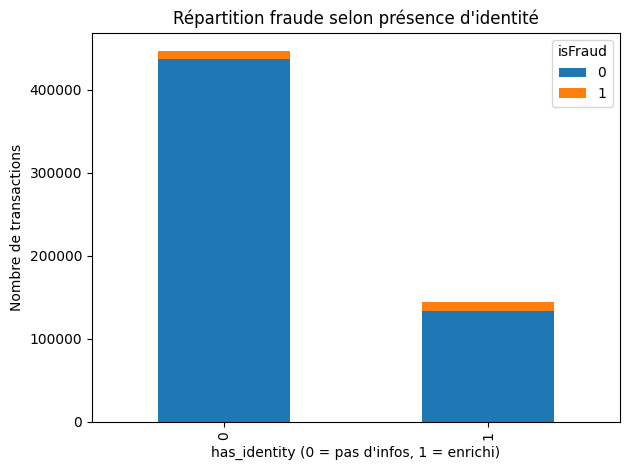

In [ ]:
fraude_pd = fraude_par_identity.toPandas()

# graphique
pivot = fraude_pd.pivot(index="has_identity", columns="isFraud", values="count")
pivot.plot(kind="bar", stacked=True)
plt.title("Répartition fraude selon présence d'identité")
plt.xlabel("has_identity (0 = pas d'infos, 1 = enrichi)")
plt.ylabel("Nombre de transactions")
plt.legend(title="isFraud")
plt.tight_layout()
plt.show()

# libere la mémoire de la variable df
cleanup(fraude_pd)

###  Interprétation

- Environ **76 %** des transactions ne possèdent **aucune information d’identité** (`has_identity = 0`)
- Les **taux de fraude sont très différents selon les groupes** :
    - **2,1 %** de fraude dans les transactions anonymes
    - **7,96 %** de fraude dans les transactions enrichies

Cela peut sembler contre-intuitif : on aurait pu s’attendre à ce que les fraudeurs évitent de fournir leur identité.  
Mais ces résultats suggèrent que :
- Les fraudeurs peuvent aussi fournir des identités **falsifiées** ou **volées**
- L'anonymat **n’est pas nécessairement un indicateur de fraude**, mais reste une information pertinente

La variable `has_identity` sera conservée comme **feature structurelle importante** pour la modélisation. Son importance réelle sera étudiée via des outils d’interprétabilité (ex. : SHAP).


### 2.4. Statistiques descriptives clés


####  Statistiques de base : TransactionAmt (montant)

In [ ]:
#statistiques descriptives ciblées

cols = ["TransactionID","TransactionAmt", "isFraud", "TransactionDT",
        "ProductCD", "card4","card6"]

df.select(cols).describe().show()

+-------+----------------+------------------+-------------------+-----------------+---------+----------------+---------------+
|summary|   TransactionID|    TransactionAmt|            isFraud|    TransactionDT|ProductCD|           card4|          card6|
+-------+----------------+------------------+-------------------+-----------------+---------+----------------+---------------+
|  count|          590540|            590540|             590540|           590540|   590540|          588963|         588969|
|   mean|       3282269.5|135.02717637246874|0.03499000914417313|7372311.310116165|     NULL|            NULL|           NULL|
| stddev|170474.358321127| 239.1625220137336| 0.1837546341784141|4617223.646539673|     NULL|            NULL|           NULL|
|    min|         2987000|             0.251|                  0|            86400|        C|american express|    charge card|
|    max|         3577539|         31937.391|                  1|         15811131|        W|            visa|d

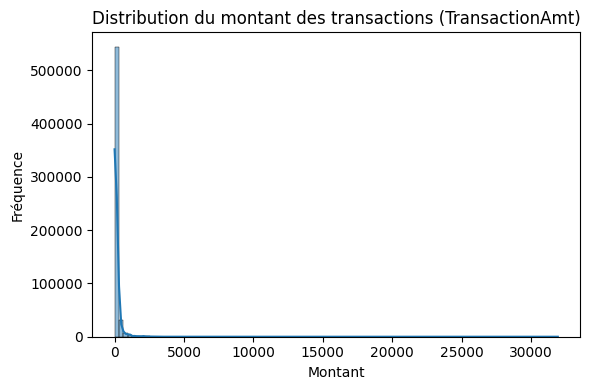

In [ ]:
df_pd = df.select("TransactionAmt").toPandas()

plt.figure(figsize=(6, 4))
sns.histplot(df_pd["TransactionAmt"], bins=100, kde=True)
plt.title("Distribution du montant des transactions (TransactionAmt)")
plt.xlabel("Montant")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# libere la mémoire de la variable df
cleanup(df_pd)

###  Interprétation (TransactionAmt)

- La distribution du montant des transactions est **très asymétrique**, avec :
  - Un pic de fréquence très élevé sur les petits montants
  - Une longue traîne droite allant jusqu'à **31 937**
- Le **montant moyen** est d’environ **135**, ce qui suggère une concentration de valeurs faibles + quelques montants extrêmes
- Il pourrait exister des **outliers**  (montants très élevés) , mais cela reste à confirmer après traitement

####  Variables catégorielles : `ProductCD`, `card4`, `card6`

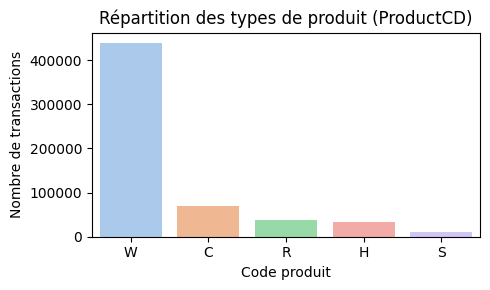

In [ ]:
product_dist = df.groupBy("ProductCD").count().toPandas().sort_values(by="count", ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(data=product_dist, x="ProductCD",hue="ProductCD", y="count", palette="pastel")
plt.title("Répartition des types de produit (ProductCD)")
plt.xlabel("Code produit")
plt.ylabel("Nombre de transactions")
plt.tight_layout()
plt.show()

# libere la mémoire de la variable df
cleanup(product_dist)

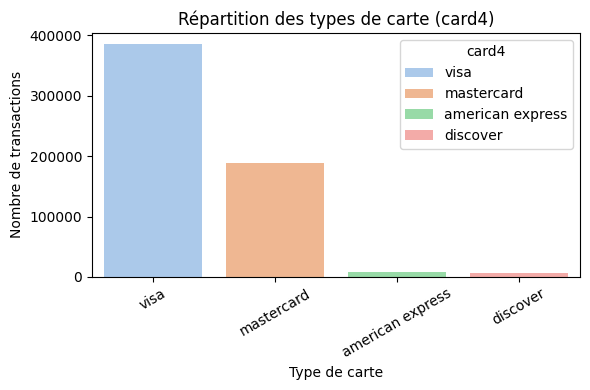

In [16]:

# GroupBy + count pour card4
card4_count = df.groupBy("card4").count().orderBy("count", ascending=False)

card4_pd = card4_count.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=card4_pd, x="card4", y="count",hue="card4", palette="pastel")
plt.title("Répartition des types de carte (card4)")
plt.xlabel("Type de carte")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

cleanup(card4_count, card4_pd)

In [17]:
df.groupBy("card6").count().orderBy("count", ascending=False).show()

+---------------+------+
|          card6| count|
+---------------+------+
|          debit|439938|
|         credit|148986|
|           NULL|  1571|
|debit or credit|    30|
|    charge card|    15|
+---------------+------+



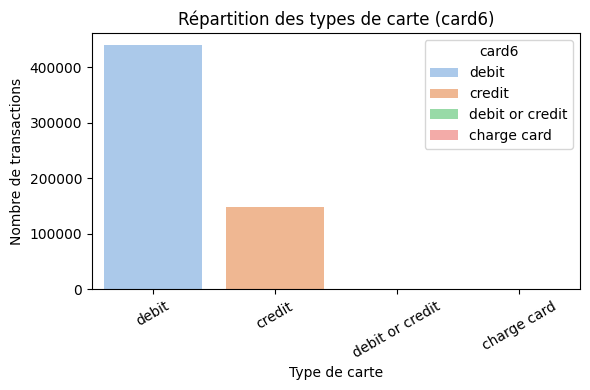

In [18]:
# GroupBy + count pour card6
card6_count = df.groupBy("card6").count().orderBy("count", ascending=False)

# Conversion en Pandas
card6_pd = card6_count.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=card6_pd, x="card6", y="count",hue="card6", palette="pastel")
plt.title("Répartition des types de carte (card6)")
plt.xlabel("Type de carte")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

cleanup(card6_count, card6_pd)

###  Interprétation (variables catégorielles)

- `ProductCD` est **largement dominée par le code “W”**, qui représente plus de 70 % des transactions
- `card4` montre une prédominance des cartes **Visa** et **Mastercard**, avec très peu d’American Express ou Discover
- `card6` est majoritairement composé de **cartes de débit**, suivies des cartes de crédit. Les autres types sont très rares, voire négligeables

 Ces distributions montrent une **forte asymétrie**, ce qui devra être pris en compte :
- Pour éviter la surreprésentation d'une modalité en modélisation
- Pour adapter l'encodage (indexation ou one-hot selon l’algo)
- Pour traiter les modalités rares ou `null` de façon spécifique (fusion, regroupement, etc.)

###  Conclusion de l’analyse exploratoire rapide (EDA brute)

Cette phase d’exploration préliminaire a permis de :

1. **Valider la structure générale du dataset**, suite à la fusion des fichiers `transaction` et `identity`
2. Confirmer un **fort déséquilibre de la variable cible `isFraud`** ( 3,5 % de fraudes)
3. Identifier une variable clé `has_identity`, qui distingue les transactions “enrichies” (24 %) des “anonymes” (76 %), et révèle un **taux de fraude 4x plus élevé chez les enrichies**
4. Visualiser les distributions des principales variables numériques (`TransactionAmt`) et catégorielles (`ProductCD`, `card4`, `card6`), toutes fortement asymétriques avec quelques modalités dominantes

 Ces analyses constituent une **base solide pour orienter les étapes suivantes** :
- Le **nettoyage ciblé** des données (valeurs manquantes, modalités rares)
- Une **EDA approfondie post-nettoyage** avec des croisements, corrélations, et outliers
- Un **feature engineering guidé par les insights observés ici**

 Nous passons maintenant à la phase **d’inspection et détection des anomalies**, pour préparer le dataset à la modélisation.

## 3. Détection et inspection des anomalies

####  Objectif de la section 

L’objectif est de repérer les problèmes potentiels de qualité de données avant le nettoyage. Cette phase permet d’anticiper :

Nous ciblons :

1. La présence de **valeurs manquantes** importantes
2. Les colonnes à **faible information** : constantes, vides ou rares
3. Les **anomalies potentielles** : valeurs aberrantes, incohérences

Cela oriente les décisions de nettoyage, d’imputation et de sélection de variables.


###  3.1. Analyse des valeurs manquantes

Avant de cibler des colonnes précises, explorons l’ensemble du jeu de données pour détecter les variables les plus lacunaires.

In [19]:
total_rows = df.count()
missing_perc = (
    df.select([(count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in df.columns])
    .toPandas()
    .T
    .rename(columns={0: "missing_perc"})
    .sort_values("missing_perc", ascending=False)
)

# Afficher les 10 colonnes les plus manquantes
print(missing_perc.head(10))

# Nettoyage mémoire
cleanup(total_rows, missing_perc)

       missing_perc
id_24      0.991962
id_25      0.991310
id_08      0.991271
id_07      0.991271
id_21      0.991264
id_26      0.991257
id_23      0.991247
id_22      0.991247
id_27      0.991247
dist2      0.936284


In [20]:
# Analyse ciblé des Valeurs manquantes
total = df.count()
cols_to_check = ["ProductCD","TransactionID","isFraud","id_24", "V138", "DeviceInfo","card6"]

df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in cols_to_check
]).show()

# Taux de val manquantes (en %)

df.select([
    round((count(when(col(c).isNull(), c)) / total), 3).alias(c) for c in cols_to_check
]).show()

+---------+-------------+-------+------+------+----------+-----+
|ProductCD|TransactionID|isFraud| id_24|  V138|DeviceInfo|card6|
+---------+-------------+-------+------+------+----------+-----+
|        0|            0|      0|585793|508595|    471874| 1571|
+---------+-------------+-------+------+------+----------+-----+

+---------+-------------+-------+-----+-----+----------+-----+
|ProductCD|TransactionID|isFraud|id_24| V138|DeviceInfo|card6|
+---------+-------------+-------+-----+-----+----------+-----+
|      0.0|          0.0|    0.0|0.992|0.861|     0.799|0.003|
+---------+-------------+-------+-----+-----+----------+-----+



###  Interprétation

L'analyse des valeurs manquantes met en évidence une **qualité de données très hétérogène** au sein du dataset.

-  Le jeu de données comporte **plus de 400 colonnes**, avec des niveaux très différents de complétude.
-  **Plus de 50 variables dépassent les 80 % de valeurs nulles**, ce qui justifie une stratégie de nettoyage rigoureuse.
-  Cas spécifiques :
  - `id_24`, `id_25`, `id_07`, `id_08`, `dist2` → plus de **99 % de valeurs manquantes** : **forts candidats à l’exclusion**
  - `DeviceInfo`, `V138` → entre **80 % et 86 % de null** : **à évaluer plus finement selon leur valeur prédictive**
  -  `ProductCD`, `TransactionID`, `isFraud`, `card6` → **complètes** ou **quasi-complètes** : **à conserver directement**

 Ces résultats sont critiques pour la suite :
- Éviter d'introduire du bruit inutile dans les modèles
- Réduire la dimensionnalité sans perte d'information


### 3.2. Colonnes constantes ou très peu informatives

In [ ]:
import math
# colonnes cnst

batch_size = 50 
constantes = []

for i in range(math.ceil(len(df.columns) / batch_size)):
    batch = df.columns[i*batch_size : (i+1)*batch_size]
    exprs = [approx_count_distinct(col(c)).alias(c) for c in batch]
    result = df.select(*batch).agg(*exprs).toPandas().T
    result.columns = ["n_unique"]
    constantes += result[result["n_unique"] == 1].index.tolist()

print(f"Colonnes constantes détectées : {len(constantes)}")
print(constantes)

cleanup(result,batch,exprs)

Colonnes constantes détectées : 0
[]


In [22]:

# On va cibler uniquement les colonnes string ou int 
schema = dict(df.dtypes)
candidats = [c for c in df.columns if schema[c] in ("string", "int")]


faibles = []

for c in candidats:
    try:
        count_df = df.groupBy(c).count().orderBy("count", ascending=False).limit(2).toPandas()
        if len(count_df) <= 3:
            total = count_df["count"].sum()
            top_pct = count_df.iloc[0]["count"] / total
            if top_pct >= 0.95:
                faibles.append((c, round(top_pct * 100, 2)))
        cleanup(count_df)
    except:
        continue


print(f" Colonnes faibles + déséquilibrées ( <= 3 modalités, top > 95%) :")
for colname, pct in faibles:
    print(f"  - {colname} : {pct}% dominante")

 Colonnes faibles + déséquilibrées ( <= 3 modalités, top > 95%) :


###  Interprétation

- Aucune **colonne constante** n’a été détectée dans le dataset (aucune avec une seule modalité)
- Aucune **colonne faiblement diversifiée et fortement déséquilibrée** (<= 3 modalités, top > 95 %) n’a été détectée non plus

 Cela suggère que les colonnes `string` et `int` actuellement présentes sont :
- Soit **suffisamment variées**
- Soit **équilibrées dans leur répartition**

 Conséquences :
- Aucune suppression immédiate nécessaire à ce stade
- Ces colonnes seront **réévaluées lors de l’EDA approfondie ou la sélection de features**


### 3.3 Analyse des anomalies : doublons, valeurs aberrantes 

####  Détection des doublons

In [ ]:
# detecter les valeurs dupliquées

# détection doublons exacts
duplicates = df.groupBy(df.columns).count().filter("count > 1")

# affiche uniquement un échantillon s'il y a des doublons
sample = duplicates.limit(5).toPandas()

if not sample.empty:
    print(" Doublons détectés (extrait) :")
    display(sample)
else:
    print(" Aucune ligne dupliquée détectée.")

cleanup(duplicates,sample)


 Aucune ligne dupliquée détectée.


####  Analyse des valeurs aberrantes

(1) Quantiles extrêmes

In [ ]:
# analyse des bornes extrêmes sur quelques variables continues clés
cols = ["TransactionAmt", "TransactionDT", "D1", "C1"]

# extraction des quantiles (1 %, 50 %, 99 %) pour détecter les outliers
quantiles = df.approxQuantile(cols, [0.01, 0.5, 0.99], 0.01)

for col, q in zip(cols, quantiles):
    print(f"{col} : 1% = {q[0]} | médiane = {q[1]} | 99% = {q[2]}")

TransactionAmt : 1% = 0.251 | médiane = 67.95 | 99% = 31937.391
TransactionDT : 1% = 86400.0 | médiane = 7397160.0 | 99% = 15811131.0
D1 : 1% = 0.0 | médiane = 2.0 | 99% = 640.0
C1 : 1% = 0.0 | médiane = 1.0 | 99% = 4685.0


(2) Détection IQR + volume d’outliers

In [25]:
from pyspark.sql.functions import col

# IQR pour TransactionAmt
q1, q3 = df.approxQuantile("TransactionAmt", [0.25, 0.75], 0.01)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Compter les valeurs en dehors de cette plage
outliers = df.filter((col("TransactionAmt") < lower) | (col("TransactionAmt") > upper))
print(f"Nb d'outliers TransactionAmt (IQR rule) : {outliers.count()}")

Nb d'outliers TransactionAmt (IQR rule) : 67800


(3) Visualisation bivariée (boxplot isFraud vs TransactionAmt)

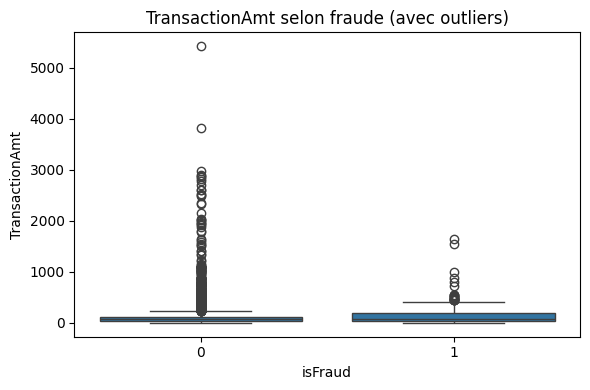

In [ ]:
# echantillonnage pour visualisation
df_pd = df.select("TransactionAmt", "isFraud").sample(fraction=0.01).toPandas()

plt.figure(figsize=(6, 4))
sns.boxplot(x="isFraud", y="TransactionAmt", data=df_pd)
plt.title("TransactionAmt selon fraude (avec outliers)")
plt.tight_layout()
plt.show()

###  Interprétation – Anomalies (TransactionAmt)

L’analyse des anomalies sur `TransactionAmt` met en évidence plusieurs points critiques :

-  **Aucune ligne dupliquée détectée**, confirmant la qualité de la fusion des fichiers `transaction` et `identity`.

-  Les quantiles extrêmes révèlent une **distribution très asymétrique** :
  - 1 % des transactions < 0,25 €
  - Médiane = 68 €
  - 1 % des transactions > 31 000 €

-  La détection formelle par la **règle IQR** identifie plus de **67 000 lignes comme outliers** (= 11 % du dataset), ce qui justifie un traitement adapté.

-  Le **boxplot croisé `TransactionAmt` vs `isFraud`** montre :
  - Que les **outliers sont présents dans les deux classes**
  - Mais qu’ils sont **plus nombreux et plus extrêmes dans la classe non frauduleuse (0)**

 Conclusion :
- Ces outliers sont **informatifs**, pas aberrants → ils **ne doivent pas être supprimés**
- Une **transformation logarithmique (`log1p`)** est recommandée pour :
  - Réduire l’effet des extrêmes
  - Stabiliser la variance
  - Améliorer la robustesse des modèles
- Un **flag binaire `is_high_amount`** sera également envisagé pour enrichir les features

 Ces traitements seront réalisés dans la phase suivante : **Feature Engineering**.


# 4. Nettoyage ciblé des données

####  Objectif de cette section : Préparer un dataset propre et exploitable pour l’analyse avancée

Cette étape vise à **corriger les défauts structurels** identifiés lors de l’exploration rapide et des détections d’anomalies, afin de :

1. Supprimer les lignes et colonnes non informatives (doublons, constantes... ) 
2. Suppression des colonnes contenant plus de 90 % de valeurs manquantes
3. **Créer des indicateurs binaires `has_X`** pour capturer la **présence d’information** dans les colonnes partiellement manquantes (80–90 % de NaN)
4. Imputer les valeurs manquantes restantes par des méthodes simples :
   - Médiane pour les variables numériques
   - `"unknown"` pour les variables catégorielles


Cette stratégie permet de **nettoyer efficacement le dataset**, sans masquer les signaux faibles potentiellement utiles pour la détection de fraude.


### 4.1 Suppression des  lignes et colonnes non informatives

L’analyse précédente (Section 3) a confirmé qu’il :

- **n’existe aucun doublon exact** dans le dataset,
- qu’aucune **colonne constante** n’a été détectée,
- et qu’aucune **colonne fortement déséquilibrée** (≤ 3 modalités, > 95 % sur une modalité) n’est présente.

 Aucune suppression n’a donc été nécessaire à ce stade.

 ### 4.2 Suppression des colonnes à forte valeur manquante

In [ ]:
# Calcul du taux de valeurs null
total_rows = df.count()
cols = df.columns

null_df = df.select([
    (count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in cols])
null_ratios = null_df.first().asDict()

# Col avec >90% de NaNn
cols_to_drop = [k for k, v in null_ratios.items() if v > 0.9]


cols_to_drop += ['TransactionID', 'DeviceInfo']  

df = df.drop(*cols_to_drop)
print(f"Colonnes supprimées : {len(cols_to_drop)}")

Colonnes supprimées : 14


 ### 4.3 Création de variables has_X pour colonnes partiellement vides

 Objectif :

Capturer la présence d’information dans certaines colonnes partiellement manquantes (80–90 % de valeurs nulles),
en générant une variable binaire has_X = 1 si la donnée est présente, 0 sinon. 

In [ ]:
#Variables déjà couvertes par has_identity ( en EDA brut)
identity_columns = ["DeviceType", "id_01", "id_30", "id_31", "DeviceInfo"]

# Calcul du taux de valeurs nulles
total_rows = df.count()

null_df = df.select([
    (count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in df.columns])
null_ratios = null_df.first().asDict()

#Colonnes entre 80% et 90% de NaNn (hors identité)
target_cols = [
    col_name for col_name, rate in null_ratios.items()
    if 0.80 <= rate <= 0.90 and col_name not in identity_columns]

print(f"Colonnes ciblées pour création de `has_X` : {len(target_cols)}")
print(target_cols)

# Création des variables has_col
for col_name in target_cols:
    new_col = f"has_{col_name}"
    df = df.withColumn(new_col, when(col(col_name).isNotNull(), 1).otherwise(0))


Colonnes ciblées pour création de `has_X` : 61
['D6', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04', 'id_09', 'id_10', 'id_14', 'id_32', 'id_33', 'id_34']


### 4.4 Imputation des valeurs manquantes restantes

#### Variables numériques : Imputation par la **médiane**, robuste face aux valeurs extrêmes.

In [ ]:
# Imputation des valeurs manquantes pour les colonnes numériques

# colonnes numériques avec NaN
total_rows = df.count()
numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"] and c != "isFraud"]

# Calcul du taux de nulls
null_df = df.select([
    (count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in numeric_cols
])
null_ratios = null_df.first().asDict()
cols_with_nulls = [k for k, v in null_ratios.items() if v > 0]

exprs = [percentile_approx(col(c), 0.5).alias(c) for c in cols_with_nulls]
medians = df.select(exprs).first().asDict()

# imputation
df = df.fillna(medians)

#### Variables catégorielles : Imputation par la chaîne `"unknown"`, permettant une gestion explicite du "manquant".

In [ ]:
# Imputation des valeurs manquantes pour les colonnes catégorielles

# Identifier les colonnes string avec des NaN
string_cols = [c for c, t in df.dtypes if t == "string"]
total_rows = df.count()

# Calcul du taux de nulls pour colonnes string
null_df_str = df.select([
    (count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in string_cols])
null_ratios_str = null_df_str.first().asDict()

# Colonnes avec des NaN
string_with_nulls = [k for k, v in null_ratios_str.items() if v > 0]

# imputation ciblée avec "unknown"
df = df.fillna({colname: "unknown" for colname in string_with_nulls})


In [ ]:
# sélectionner quelques colonnes numériques et catégorielles avec des NaN
colonnes_a_verifier = ["D6", "D8", "V138", "card6", "V310", "ProductCD", "id_38", "V139"]

# afficher un échantillon
df.select(colonnes_a_verifier).show(5)

# Vérification du taux de valeurs manquantes (doit être 0)
df.select([
    (count(when(col(c).isNull(), c)) / df.count()).alias(c)
    for c in colonnes_a_verifier
]).show()

+---+------+----+------+-----+---------+-------+----+
| D6|    D8|V138| card6| V310|ProductCD|  id_38|V139|
+---+------+----+------+-----+---------+-------+----+
|0.0|37.875| 0.0|credit|  0.0|        W|unknown| 1.0|
|0.0|37.875| 0.0|credit|  0.0|        W|unknown| 1.0|
|0.0|37.875| 0.0| debit|  0.0|        W|unknown| 1.0|
|0.0|37.875| 0.0| debit|354.0|        W|unknown| 1.0|
|0.0|37.875| 0.0|credit|  0.0|        H|      T| 0.0|
+---+------+----+------+-----+---------+-------+----+
only showing top 5 rows

+---+---+----+-----+----+---------+-----+----+
| D6| D8|V138|card6|V310|ProductCD|id_38|V139|
+---+---+----+-----+----+---------+-----+----+
|0.0|0.0| 0.0|  0.0| 0.0|      0.0|  0.0| 0.0|
+---+---+----+-----+----+---------+-----+----+



###  Interprétation – Imputation des valeurs manquantes

Cette phase finale du nettoyage a permis de **rendre le dataset entièrement exploitable**, sans valeurs manquantes bloquantes :

####  Colonnes supprimées
-  **14 colonnes** ont été supprimées car elles contenaient **plus de 90 % de valeurs manquantes**.
- Cela inclut des colonnes peu exploitables ou redondantes, comme `TransactionID` et `DeviceInfo`.

####  Création des variables `has_X`
-  **61 indicateurs binaires `has_X`** ont été créés pour les colonnes partiellement vides (entre 80 % et 90 % de NaN).
- Ces flags permettent d’**encoder la présence d'information** sans imputation directe.

####  Imputation des valeurs manquantes restantes
-  **Toutes les colonnes numériques restantes** ont été **imputées par leur médiane** — une méthode robuste aux outliers et efficace sur des distributions asymétriques.
-  Les **colonnes catégorielles** avec des valeurs manquantes ont été imputées avec `"unknown"`, ce qui :
  - **Préserve l'information de "donnée absente"**
  - Facilite l'encodage ultérieur sans introduire d'erreurs

####  Bilan
-  Le **taux de valeurs nulles est désormais de 0 %** sur l’ensemble du dataset.
- Le dataset est **nettoyé, cohérent et allégé**, tout en **préservant un maximum d'information pertinente** pour la détection de fraude.

Il est maintenant **prêt pour l’analyse exploratoire avancée et le feature engineering.**

# 5. Analyse exploratoire approfondie (EDA avancée).

####  Objectif de cette section : Explorer les structures fines du dataset et les patterns de fraude

Cette étape vise à **approfondir l’analyse statistique** après le nettoyage, afin de :

1. Identifier les **relations entre les variables et la cible `isFraud`**
2. Détecter des **corrélations ou effets de seuils**
3. Repérer les **groupes à risque élevé de fraude**
4. Préparer le terrain pour un **feature engineering guidé par les données**

L’analyse sera structurée selon 4 axes principaux :

1. **Analyse croisée `isFraud` vs variables clés**  
   - Numériques : `TransactionAmt`, `D1`, `C1`, etc.  
   - Catégorielles : `ProductCD`, `card4`, `card6`, `P_emaildomain`, etc.

2. **Analyse temporelle**  
   - Étude de l’évolution des fraudes dans le temps (`TransactionDT`, `D*`)

3. **Analyse par groupe spécifique**  
   - Variables indicatrices (`has_identity`, `has_X`, etc.)
   - Segments à risque (montants élevés, absence d'identité, etc.)

4. **Analyse des corrélations numériques**  
   - Détection de redondances  
   - Préparation à la sélection de variables ou réduction de dimension

### 5.1 Analyse croisée : `TransactionAmt` vs `isFraud`

####  Objectif : Étudier la répartition du montant des transactions (`TransactionAmt`) en fonction de la présence ou non de fraude

Le montant d’une transaction est une **variable clé** dans les systèmes de détection de fraude.


In [ ]:
# Statistiques par classe (fraude vs non fraude)
df.groupBy("isFraud").agg(
    count("*").alias("n_obs"),
    round(mean("TransactionAmt"), 2).alias("mean_amt"),
    round(expr("percentile_approx(TransactionAmt, 0.5)"), 2).alias("median_amt"),
    round(expr("percentile_approx(TransactionAmt, 0.9)"), 2).alias("p90_amt"),
    round(max("TransactionAmt"), 2).alias("max_amt")
).orderBy("isFraud").show()

+-------+------+--------+----------+-------+--------+
|isFraud| n_obs|mean_amt|median_amt|p90_amt| max_amt|
+-------+------+--------+----------+-------+--------+
|      0|569877|  134.51|      68.5|  266.0|31937.39|
|      1| 20663|  149.24|      75.0|  335.0|  5191.0|
+-------+------+--------+----------+-------+--------+



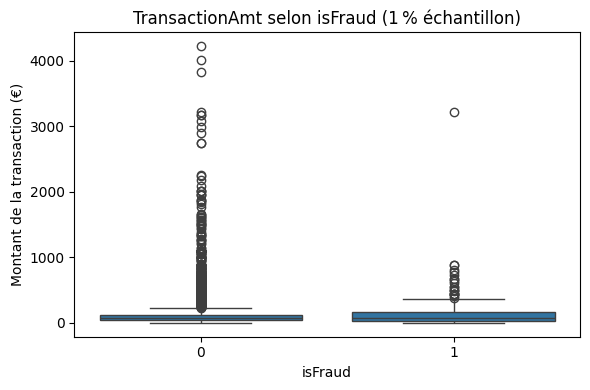

In [ ]:
# échantillon pour visualisation
df_pd = df.select("TransactionAmt", "isFraud").sample(fraction=0.01).toPandas()

plt.figure(figsize=(6, 4))
sns.boxplot(x="isFraud", y="TransactionAmt", data=df_pd)
plt.title("TransactionAmt selon isFraud (1 % échantillon)")
plt.xlabel("isFraud")
plt.ylabel("Montant de la transaction (euro)")
plt.tight_layout()
plt.show()

cleanup(df_pd)

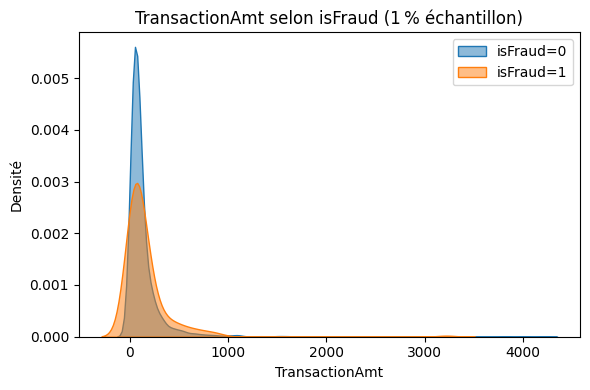

In [ ]:
plt.figure(figsize=(6, 4))
for label in [0, 1]:
    subset = df_pd[df_pd["isFraud"] == label]
    sns.kdeplot(subset["TransactionAmt"], label=f"isFraud={label}", fill=True, alpha=0.5)
plt.legend()
plt.title("TransactionAmt selon isFraud (1 % échantillon)")
plt.xlabel("TransactionAmt")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

df_pd_full = df.select("TransactionAmt", "isFraud").toPandas()

fraud = df_pd_full[df_pd_full["isFraud"] == 1]["TransactionAmt"]
nonfraud = df_pd_full[df_pd_full["isFraud"] == 0]["TransactionAmt"]

# Test de Mann-Whitney 
stat, p_value = mannwhitneyu(fraud, nonfraud, alternative="two-sided")

print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

Statistic: 5858540820.5
P-value: 0.22590783497976064


###  Interprétation – `TransactionAmt` vs `isFraud`

- Les transactions frauduleuses ont un **montant moyen plus élevé** (149 €) que les non frauduleuses (135 €).
- La **médiane** suit la même tendance : 75 € en fraude contre 68,5 € en non-fraude.
- Les **fraudes dépassent rarement 5 000 €**, alors que certaines transactions non frauduleuses montent jusqu’à **32 000 €**.
- Le boxplot montre des **valeurs extrêmes fréquentes en non-fraude**, mais des montants **légèrement plus élevés dans les fraudes typiques**.
- La **courbe de densité** montre une concentration des fraudes sur des montants faibles à intermédiaires, et une plus grande dispersion des non-fraudes avec une queue plus longue vers les montants élevés.

 Conclusion :
- `TransactionAmt` est une variable **informative** à conserver.
- Elle sera possiblement **transformée (log1p)** et **binarisée (`is_high_amount`)** dans le Feature Engineering.

### Analyse croisée : `D1` vs `isFraud` 

####  Objectif : Étudier l'effet du délai comportemental `D1` selon la classe de fraude

`D1` correspond à un **delta temporel** lié à l’activité de l’utilisateur (souvent le nombre de jours depuis la dernière interaction connue).  
Des valeurs extrêmes ou très faibles peuvent signaler un comportement inhabituel.

In [ ]:
df.groupBy("isFraud").agg(
    count("*").alias("n_obs"),
    round(mean("D1"), 2).alias("mean_D1"),
    round(expr("percentile_approx(D1, 0.5)"), 2).alias("median_D1"),
    round(expr("percentile_approx(D1, 0.9)"), 2).alias("p90_D1"),
    round(max("D1"), 2).alias("max_D1")
).orderBy("isFraud").show()

+-------+------+-------+---------+------+------+
|isFraud| n_obs|mean_D1|median_D1|p90_D1|max_D1|
+-------+------+-------+---------+------+------+
|      0|569877|  96.16|      3.0| 366.0| 640.0|
|      1| 20663|  38.63|      0.0| 128.0| 637.0|
+-------+------+-------+---------+------+------+



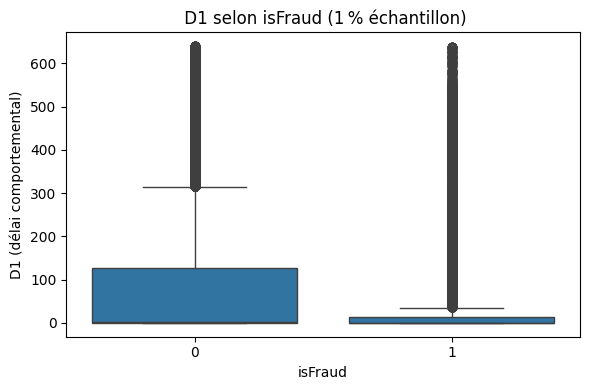

In [ ]:
df_pd0 = df.select("D1", "isFraud").where(col("D1").isNotNull()).toPandas()

plt.figure(figsize=(6, 4))
sns.boxplot(x="isFraud", y="D1", data=df_pd0)
plt.title(" D1 selon isFraud (1% échantillon)")
plt.xlabel("isFraud")
plt.ylabel("D1 (délai comportemental)")
plt.tight_layout()
plt.show()
# Libération de la mémoire
cleanup(df_pd0)

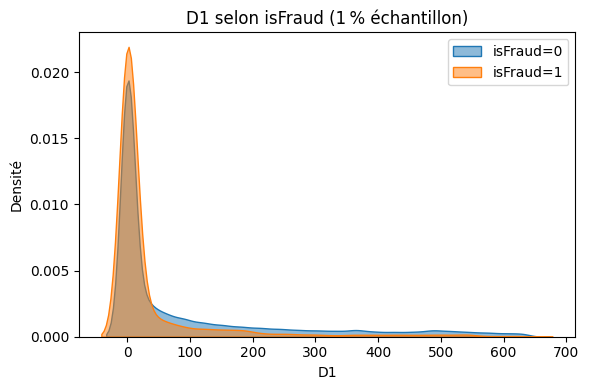

In [ ]:
plt.figure(figsize=(6, 4))
for label in [0, 1]:
    subset = df_pd0[df_pd0["isFraud"] == label]
    sns.kdeplot(subset["D1"], label=f"isFraud={label}", fill=True, alpha=0.5)
plt.legend()
plt.title("D1 selon isFraud (1% échantillon)")
plt.xlabel("D1")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()
cleanup(df_pd0)

###  Interprétation – `D1` vs `isFraud`

- Le **délai comportemental (`D1`) est nettement plus faible en cas de fraude** :  
  - Médiane = 0 pour les fraudes vs 3 pour les non-fraudes  
  - Moyenne = 38 en fraude vs 96 en non-fraude
- Cela suggère que les fraudes sont souvent associées à des **comptes nouvellement actifs** ou à des comportements récents et rapides.
- Le boxplot confirme que les **valeurs extrêmes (outliers) sont bien plus fréquentes chez les non-frauduleux**.

 Conclusion :
- `D1` est une variable **hautement informative** pour détecter des comportements suspects.
- Elle sera conservée telle quelle, avec possibilité d’ajouter une variable dérivée binaire du type `is_recent_activity`.


### Analyse croisée : `C1` vs `isFraud`

####  Objectif : Étudier la distribution de la variable `C1` en fonction de la fraude

`C1` fait partie des variables comportementales agrégées (souvent liées à l’usage de la carte ou du compte).  
Des valeurs extrêmes peuvent refléter un **usage intensif, automatisé ou anormal**.

In [ ]:
df.groupBy("isFraud").agg(
    count("*").alias("n_obs"),
    round(mean("C1"), 2).alias("mean_C1"),
    round(expr("percentile_approx(C1, 0.5)"), 2).alias("median_C1"),
    round(expr("percentile_approx(C1, 0.9)"), 2).alias("p90_C1"),
    round(max("C1"), 2).alias("max_C1")
).orderBy("isFraud").show()

+-------+------+-------+---------+------+------+
|isFraud| n_obs|mean_C1|median_C1|p90_C1|max_C1|
+-------+------+-------+---------+------+------+
|      0|569877|  13.31|      1.0|   6.0|4685.0|
|      1| 20663|  35.54|      2.0|  30.0|4682.0|
+-------+------+-------+---------+------+------+



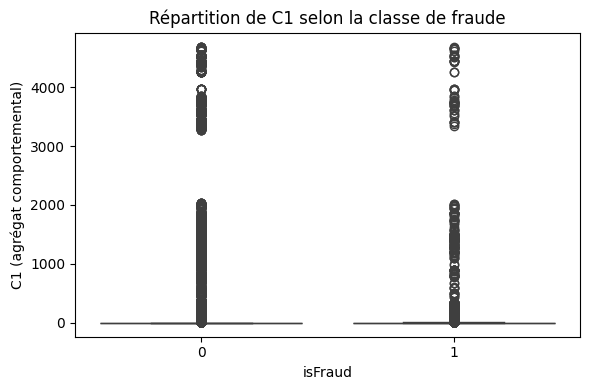

In [ ]:
df_pd1 = df.select("C1", "isFraud").where(col("C1").isNotNull()).toPandas()

plt.figure(figsize=(6, 4))
sns.boxplot(x="isFraud", y="C1", data=df_pd1 )
plt.title(" Répartition de C1 selon la classe de fraude")
plt.xlabel("isFraud")
plt.ylabel("C1 (agrégat comportemental)")
plt.tight_layout()
plt.show()

cleanup(df_pd1)

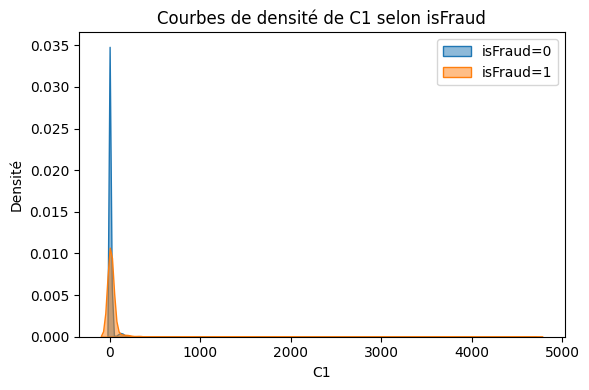

In [ ]:
plt.figure(figsize=(6, 4))
for label in [0, 1]:
    subset = df_pd1[df_pd1["isFraud"] == label]
    sns.kdeplot(subset["C1"], label=f"isFraud={label}", fill=True, alpha=0.5)
plt.legend()
plt.title("Courbes de densité de C1 selon isFraud")
plt.xlabel("C1")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()
cleanup(df_pd1)

###  Interprétation – `C1` vs `isFraud`

- Les transactions frauduleuses présentent des **valeurs moyennes de `C1` beaucoup plus élevées** (35,5 contre 13,3).
- La **médiane est aussi doublée en fraude** (2 contre 1), avec un 90e percentile à 30 contre 6.
- Cela suggère que **les fraudeurs sont associés à une intensité comportementale beaucoup plus forte** sur ce compteur.
- Le boxplot montre une **distribution plus étalée en fraude**, avec également des outliers dans les deux classes.

 Conclusion :
- `C1` est une variable **très informative** pour capturer des comportements atypiques.
- À conserver pour la modélisation, avec éventuelle **normalisation** ou **binning** selon sa distribution.


### Analyse croisée du ratio : `C1/D1` vs `isFraud`

####  Objectif : Explorer  le **rapport comportementale  entre (`C1`) et (`D1`)** permet de mieux distinguer les fraudes.

Ce ratio `C1 / D1` capture une idée d’**intensité récente** : un comportement très fréquent dans un court laps de temps peut être suspect.

####  Construction du ratio `C1_sur_D1`

In [ ]:
# Création de la feature ratio qu'on recréera dans feature construction .
df_test = df.withColumn("C1_sur_D1", when(col("D1") == 0, col("C1")).otherwise(col("C1") / (col("D1") + 1e-6)))
df_test.groupBy("isFraud").agg(
    count("*").alias("n_obs"),
    round(mean("C1_sur_D1"), 2).alias("mean_ratio"),
    round(expr("percentile_approx(C1_sur_D1, 0.5)"), 2).alias("median_ratio"),
    round(expr("percentile_approx(C1_sur_D1, 0.9)"), 2).alias("p90_ratio"),
    round(max("C1_sur_D1"), 2).alias("max_ratio")
).orderBy("isFraud").show()

+-------+------+----------+------------+---------+---------+
|isFraud| n_obs|mean_ratio|median_ratio|p90_ratio|max_ratio|
+-------+------+----------+------------+---------+---------+
|      0|569877|      6.59|         1.0|      2.0|   4685.0|
|      1| 20663|     25.86|         1.0|     16.0|   4682.0|
+-------+------+----------+------------+---------+---------+



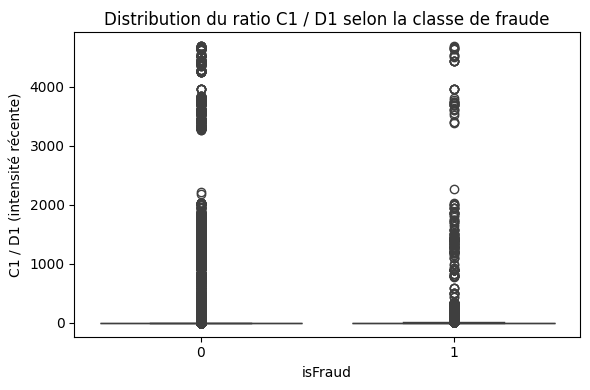

In [ ]:
df_sample = df_test.select("C1_sur_D1", "isFraud").where(col("C1_sur_D1").isNotNull()).toPandas()

plt.figure(figsize=(6, 4))
sns.boxplot(x="isFraud", y="C1_sur_D1", data=df_sample)
plt.title("Distribution du ratio C1 / D1 selon la classe de fraude")
plt.xlabel("isFraud")
plt.ylabel("C1 / D1 (intensité récente)")
plt.tight_layout()
plt.show()

cleanup(df_sample)


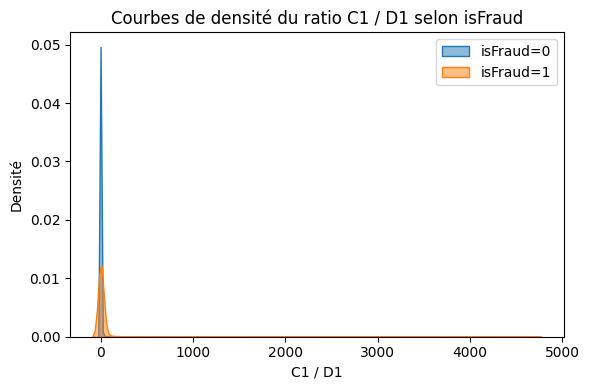

In [ ]:
plt.figure(figsize=(6, 4))
for label in [0, 1]:
    subset = df_sample[df_sample["isFraud"] == label]
    sns.kdeplot(subset["C1_sur_D1"], label=f"isFraud={label}", fill=True, alpha=0.5)
plt.legend()
plt.title("Courbes de densité du ratio C1 / D1 selon isFraud")
plt.xlabel("C1 / D1")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import mannwhitneyu

df_pd_full = df_test.select("C1_sur_D1", "isFraud").toPandas()

fraud = df_pd_full[df_pd_full["isFraud"] == 1]["C1_sur_D1"]
nonfraud = df_pd_full[df_pd_full["isFraud"] == 0]["C1_sur_D1"]

# Test de Mann-Whitney 
stat, p_value = mannwhitneyu(fraud, nonfraud, alternative="two-sided")

print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

Statistic: 7844512023.5
P-value: 0.0


####  Interprétation – `C1 / D1` vs `isFraud`

- Les deux classes ont une **médiane identique (1.0)**, ce qui suggère qu’une grande partie des transactions ont un ratio modéré.
- En revanche :
  - La **moyenne est presque 4 fois plus élevée en cas de fraude** (25.86 vs 6.59)
  - Le **90e percentile explose en cas de fraude** (16 vs 2)
- Cela indique qu’**une fraction non négligeable des fraudes est associée à une activité très intense sur un laps de temps court** (haut `C1`, bas `D1`)
- Le boxplot confirme la **présence d’outliers élevés chez les fraudes**, et une **dispersion plus marquée**.

 **Conclusion :** le ratio `C1 / D1` semble **informativement puissant**, mais **fortement asymétrique**.
- Il pourrait être **log-transformé (`log1p`)**
- Ou binarisé (`is_high_intensity`) dans le Feature Engineering

### Analyse croisée : `ProductCD` vs `isFraud` [Catégorielle]

####  Objectif : Étudier si certains types de produits (`ProductCD`) sont plus exposés à la fraude

La variable `ProductCD` indique le **type de produit acheté** (catégorie de transaction).  
Certaines catégories peuvent être **ciblées préférentiellement par les fraudeurs** (ex : produits numériques, abonnements).


In [ ]:
fraude_par_produit = (
    df.groupBy("ProductCD", "isFraud")
      .count()
      .groupBy("ProductCD")
      .pivot("isFraud", [0, 1])
      .sum("count")
      .fillna(0))

fraude_par_produit = fraude_par_produit.withColumn(
    "taux_fraude_%", round(col("1") / (col("0") + col("1")) * 100, 2)
).orderBy("taux_fraude_%", ascending=False)

fraude_par_produit.show()

+---------+------+----+-------------+
|ProductCD|     0|   1|taux_fraude_%|
+---------+------+----+-------------+
|        C| 60511|8008|        11.69|
|        S| 10942| 686|          5.9|
|        H| 31450|1574|         4.77|
|        R| 36273|1426|         3.78|
|        W|430701|8969|         2.04|
+---------+------+----+-------------+



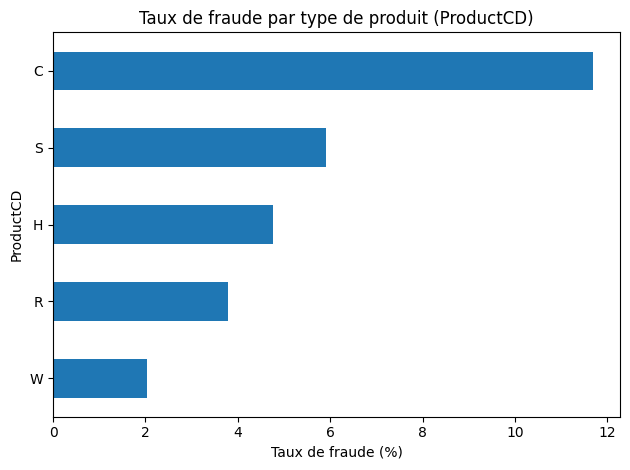

In [ ]:
fraude_pd = df.groupBy("ProductCD", "isFraud").count().toPandas()
pivot = fraude_pd.pivot(index="ProductCD", columns="isFraud", values="count").fillna(0)
pivot["taux_fraude_%"] = (pivot[1] / (pivot[0] + pivot[1]) * 100).round(2)


pivot[["taux_fraude_%"]].sort_values(by="taux_fraude_%").plot(kind="barh", legend=False)
plt.title("Taux de fraude par type de produit (ProductCD)")
plt.xlabel("Taux de fraude (%)")
plt.ylabel("ProductCD")
plt.tight_layout()
plt.show()

cleanup(fraude_pd, pivot)

In [ ]:
from scipy.stats import chi2_contingency

# table de contingence
contingency = pd.crosstab(df.select("ProductCD", "isFraud").toPandas()["ProductCD"],
                          df.select("ProductCD", "isFraud").toPandas()["isFraud"])

# Test du chi2
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4e}")

Statistic: 16742.17
P-value: 0.0000e+00


###  Interprétation – `ProductCD` vs `isFraud`

- Le produit **`C` affiche un taux de fraude élevé** : près de **11,7 %**, bien supérieur aux autres catégories.
- À l’inverse, le produit **`W` est le plus fréquent (430 000 lignes)** mais avec un taux de fraude très bas (**2 %**).
- Les autres produits (`S`, `H`, `R`) ont un **taux modéré entre 3,7 % et 6 %**.

 Conclusion :
- `ProductCD` est une variable catégorielle **fortement discriminante**.
- Il est pertinent de la conserver telle quelle (via encodage) et de créer un **flag `is_product_C`** si besoin.


### Analyse croisée : `card4` vs `isFraud` [Catégorielle]

####  Objectif : Étudier l’influence du type de carte (`card4`) sur le risque de fraude

`card4` désigne le **réseau de la carte bancaire** utilisée (Visa, Mastercard, etc.).  
Certaines marques peuvent être **plus exposées** en raison de leur popularité ou de failles spécifiques.

In [ ]:
fraude_par_card4 = (
    df.groupBy("card4", "isFraud")
      .count()
      .groupBy("card4")
      .pivot("isFraud", [0, 1])
      .sum("count")
      .fillna(0)
)

fraude_par_card4 = fraude_par_card4.withColumn(
    "taux_fraude_%", round(col("1") / (col("0") + col("1")) * 100, 2)
).orderBy("taux_fraude_%", ascending=False)

fraude_par_card4.show()

+----------------+------+-----+-------------+
|           card4|     0|    1|taux_fraude_%|
+----------------+------+-----+-------------+
|        discover|  6137|  514|         7.73|
|            visa|371394|13373|         3.48|
|      mastercard|182721| 6496|         3.43|
|american express|  8089|  239|         2.87|
|         unknown|  1536|   41|          2.6|
+----------------+------+-----+-------------+



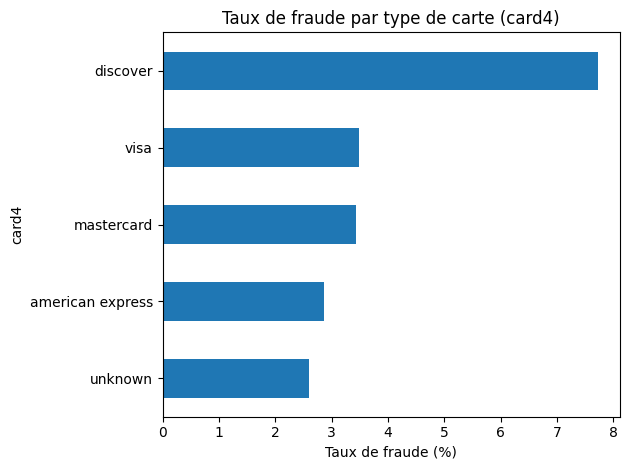

In [ ]:
fraude_pd = df.groupBy("card4", "isFraud").count().toPandas()
pivot = fraude_pd.pivot(index="card4", columns="isFraud", values="count").fillna(0)
pivot["taux_fraude_%"] = (pivot[1] / (pivot[0] + pivot[1]) * 100).round(2)


pivot[["taux_fraude_%"]].sort_values(by="taux_fraude_%").plot(kind="barh", legend=False)
plt.title("Taux de fraude par type de carte (card4)")
plt.xlabel("Taux de fraude (%)")
plt.ylabel("card4")
plt.tight_layout()
plt.show()

cleanup(fraude_pd, pivot)

In [ ]:
from scipy.stats import chi2_contingency

contingency = pivot[[0,1]]  

# Test du chi2
chi2_stat, p_val, dof, expected = chi2_contingency(contingency)

print(f"Chi² statistic: {chi2_stat:.2f}")
print(f"P-value: {p_val:.4e}")


Chi² statistic: 368.90
P-value: 1.4528e-78


###  Interprétation – `card4` vs `isFraud`

- La carte **Discover** présente le **taux de fraude le plus élevé (7,73 %)**, bien au-dessus des autres réseaux.
- Les cartes **Visa** et **Mastercard**, très répandues, affichent un taux proche de **3,4 %**, dans la moyenne globale.
- Les cartes **American Express** et les cas **inconnus** sont moins exposés (= 2,6–2,9 %).

 Conclusion :
- `card4` est une variable catégorielle **modérément informative**, à **conserver pour la modélisation**.
- Il peut être pertinent de regrouper les modalités rares ou créer un flag `is_discover_card` dans le Feature Engineering.


### Analyse croisée : `card6` vs `isFraud` [catégorielle]

####  Objectif : Évaluer si le type de carte (`card6`) influence le risque de fraude

`card6` indique la **nature de la carte bancaire** : débit, crédit, prépayée, etc.  
Certains types peuvent être **plus vulnérables** selon leur usage ou leur vérification d’identité.

In [ ]:
fraude_par_card6 = (
    df.groupBy("card6", "isFraud")
      .count()
      .groupBy("card6")
      .pivot("isFraud", [0, 1])
      .sum("count")
      .fillna(0)
)

fraude_par_card6 = fraude_par_card6.withColumn(
    "taux_fraude_%", round(col("1") / (col("0") + col("1")) * 100, 2)
).orderBy("taux_fraude_%", ascending=False)

fraude_par_card6.show()

+---------------+------+-----+-------------+
|          card6|     0|    1|taux_fraude_%|
+---------------+------+-----+-------------+
|         credit|139036| 9950|         6.68|
|        unknown|  1532|   39|         2.48|
|          debit|429264|10674|         2.43|
|    charge card|    15|    0|          0.0|
|debit or credit|    30|    0|          0.0|
+---------------+------+-----+-------------+



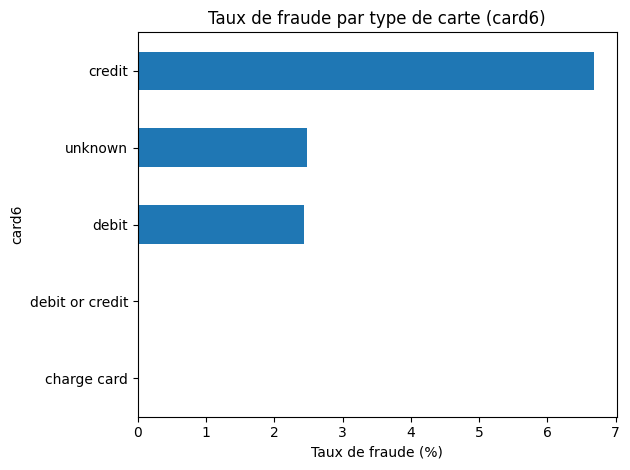

In [ ]:
fraude_pd = df.groupBy("card6", "isFraud").count().toPandas()
pivot = fraude_pd.pivot(index="card6", columns="isFraud", values="count").fillna(0)
pivot["taux_fraude_%"] = (pivot[1] / (pivot[0] + pivot[1]) * 100).round(2)

pivot[["taux_fraude_%"]].sort_values(by="taux_fraude_%").plot(kind="barh", legend=False)
plt.title("Taux de fraude par type de carte (card6)")
plt.xlabel("Taux de fraude (%)")
plt.ylabel("card6")
plt.tight_layout()
plt.show()
cleanup(fraude_pd, pivot)

###  Interprétation – `card6` vs `isFraud`

- Les cartes de **crédit** présentent un **taux de fraude élevé (6,68 %)**, bien supérieur aux cartes de débit (2,43 %).
- Les types rares (`charge card`, `debit or credit`) affichent **zéro fraude**, mais avec un **nombre d’occurrences trop faible** pour conclure.
- Les cartes **"unknown"** restent modérément exposées (2,48 %).

 Conclusion :
- Le type de carte (`card6`) est **clairement discriminant**, surtout entre **crédit** et **débit**.
- À conserver pour la modélisation, avec une possible transformation binaire : `is_credit_card`.


### Analyse croisée : `card4` vs `card6` [catégorielle]

####  Objectif : Comprendre les combinaisons les plus fréquentes entre **réseau de carte** (`card4`) et **type de carte** (`card6`)

Ce croisement permet d’identifier les **paires les plus courantes** dans les transactions.  
Certaines combinaisons peuvent être **plus représentatives du comportement normal**, ou à l’inverse, **plus exposées à la fraude**.

In [ ]:
df.select("card6", "card4").groupBy("card6", "card4").count().orderBy("count", ascending=False).show()

+---------------+----------------+------+
|          card6|           card4| count|
+---------------+----------------+------+
|          debit|            visa|301023|
|          debit|      mastercard|138415|
|         credit|            visa| 83732|
|         credit|      mastercard| 50772|
|         credit|american express|  8175|
|         credit|        discover|  6304|
|        unknown|         unknown|  1565|
|          debit|        discover|   347|
|          debit|american express|   144|
|debit or credit|      mastercard|    30|
|    charge card|            visa|    12|
|          debit|         unknown|     9|
|        unknown|american express|     6|
|         credit|         unknown|     3|
|    charge card|american express|     3|
+---------------+----------------+------+



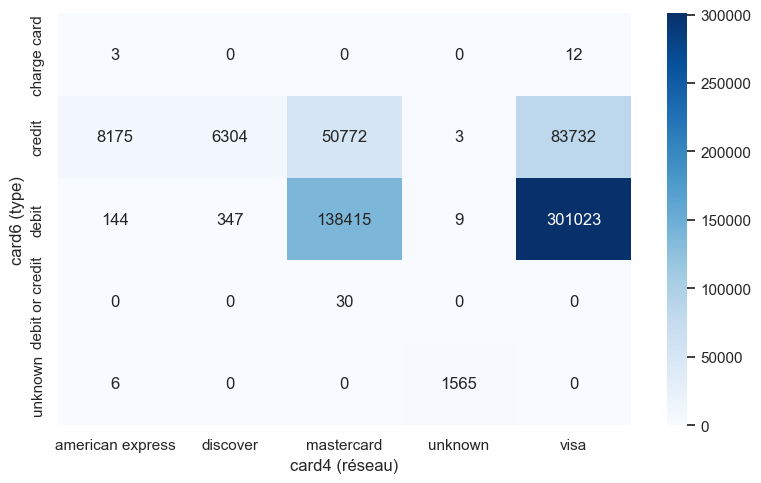

In [ ]:

sample_df = df.select("card6", "card4").toPandas()

# Table croisée
cross_tab = pd.crosstab(sample_df["card6"], sample_df["card4"])

plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="Blues")
plt.xlabel("card4 (réseau)")
plt.ylabel("card6 (type)")
plt.tight_layout()
plt.show()
cleanup(sample_df, cross_tab)

###  Interprétation – Fréquences conjointes `card4` × `card6`

- Les combinaisons **les plus fréquentes** sont :
  - `debit + visa` (= 300 000 lignes)
  - `debit + mastercard` (= 140 000)
  - `credit + visa` (= 83 000)
- Certaines combinaisons sont **quasi absentes** : `charge card`, `unknown`, ou des croisements peu fréquents comme `credit + discover`.

 Conclusion :
- La majorité des transactions s'appuie sur des cartes **de débit Visa ou Mastercard**, ce qui représente un **comportement normal majoritaire**.
- Ces croisements peuvent être **encodés comme features combinées** (`card4_card6`) ou binarisés pour détecter des cas rares.


## 5.2 Analyse temporelle de la fraude

####  Objectif : Étudier l’évolution de la fraude dans le temps

Le champ `TransactionDT` est une **temps relatif exprimé en secondes** : il représente le **nombre de secondes depuis un point de référence** inconnu.  
Même s’il ne s’agit pas d’une date-calendrier, il permet d’**analyser des tendances temporelles** et de repérer des **pics de fraude**.

###  Préparation : transformation en jours

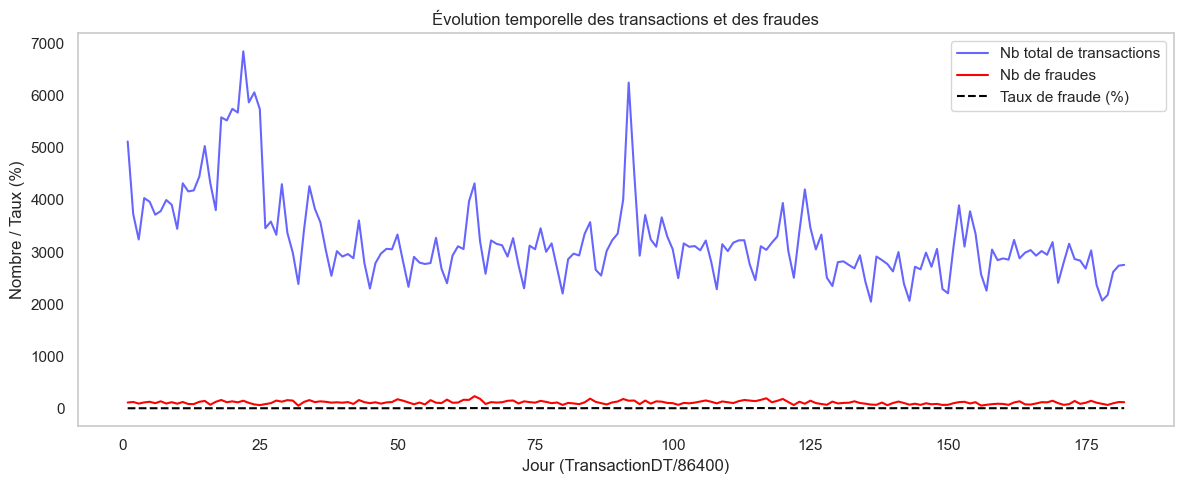

In [ ]:
df = df.withColumn("TransactionDay", floor(col("TransactionDT") / 86400))

agg = ( df.groupBy("TransactionDay")
      .agg(count("*").alias("nb_total"),
          count(when(col("isFraud") == 1, True)).alias("nb_fraudes"))
      .orderBy("TransactionDay"))

agg = agg.withColumn("taux_fraude", (col("nb_fraudes") / col("nb_total")) * 100)

agg_pd = agg.toPandas()

plt.figure(figsize=(12, 5))
plt.plot(agg_pd["TransactionDay"], agg_pd["nb_total"], label="Nb total de transactions", color="blue", alpha=0.6)
plt.plot(agg_pd["TransactionDay"], agg_pd["nb_fraudes"], label="Nb de fraudes", color="red")
plt.plot(agg_pd["TransactionDay"], agg_pd["taux_fraude"], label="Taux de fraude (%)", color="black", linestyle="--")

plt.xlabel("Jour (TransactionDT/86400)")
plt.ylabel("Nombre/Taux(%)")
plt.title("Évolution temporelle des transactions et des fraudes")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

###  Interprétation – Évolution temporelle de la fraude

- Le volume de **transactions non frauduleuses** varie fortement sur les 200 premiers jours, avec plusieurs **pics d’activité**, notamment autour du jour 25 et 90.
- Les **fraudes restent relativement stables**, autour de **200 à 300 cas par jour**, avec **moins de volatilité**.
- Aucun **pic brutal** ou **saison de fraude identifiable**, mais quelques hausses modérées.

 Conclusion :
- `TransactionDT` converti en jours permet d’**exploiter des tendances globales**.
- Il est pertinent de créer une feature `day` ou `week`, voire un flag `is_weekend` ou `is_day_peak` pour le Feature Engineering.

## 5.3 Analyse des groupes spécifiques (`has_X`)

####  Objectif : Étudier l’impact de certaines variables binaires créées sur le taux de fraude

Durant la phase de nettoyage, plusieurs variables indicatrices (`has_X`) ont été ajoutées pour **préserver l'information de présence/absence** dans certaines colonnes très lacunaires, sans alourdir le dataset.

Nous allons explorer leur impact en trois étapes :

1. **`has_identity`** : distingue les transactions enrichies par des données d’identité
2. **Vue d’ensemble des `has_X`** : taux de présence + taux de fraude
3. **Zoom sur les plus pertinentes** (ex. : `has_D12`, `has_D14`, `has_id_03`, `has_D8`)


### Taux de fraude : `has_identity` 

In [ ]:
fraude_par_identity = (
    df.groupBy("has_identity", "isFraud")
      .count()
      .groupBy("has_identity")
      .pivot("isFraud", [0, 1])
      .sum("count")
      .fillna(0))

fraude_par_identity = fraude_par_identity.withColumn(
    "taux_fraude_%", round(col("1") / (col("0") + col("1")) * 100, 2)
).orderBy("has_identity")

fraude_par_identity.show()

+------------+------+-----+-------------+
|has_identity|     0|    1|taux_fraude_%|
+------------+------+-----+-------------+
|           0|436962| 9345|         2.09|
|           1|132915|11318|         7.85|
+------------+------+-----+-------------+



###  Interprétation – `has_identity` vs `isFraud`

Les résultats sont cohérents avec EDA brut :  
la variable `has_identity` conserve son **pouvoir discriminant élevé**, même après nettoyage.

Elle est confirmée comme feature robuste à conserver pour la modélisation.


### Aperçu global des `has_X`

####  Objectif : Identifier les indicateurs `has_X` dont la présence pourrait signaler un risque de fraude

Les colonnes concernées avaient un **taux de valeurs manquantes (80–90 %)**.  
Plutôt que de les supprimer, nous avons choisi de créer des **indicateurs binaires `has_X`**, qui indiquent simplement si la donnée est **présente (`1`) ou absente (`0`)**.


Cette section vise à :
-  Visualiser le **taux de présence** des indicateurs `has_X` dans le dataset
-  Calculer leur **taux de fraude** (quand `has_X = 1`)

L’objectif est d’identifier les variables partiellement renseignées qui, lorsqu’elles sont présentes, sont **associées à un risque de fraude plus élevé**, et méritent donc une analyse individuelle plus poussée.


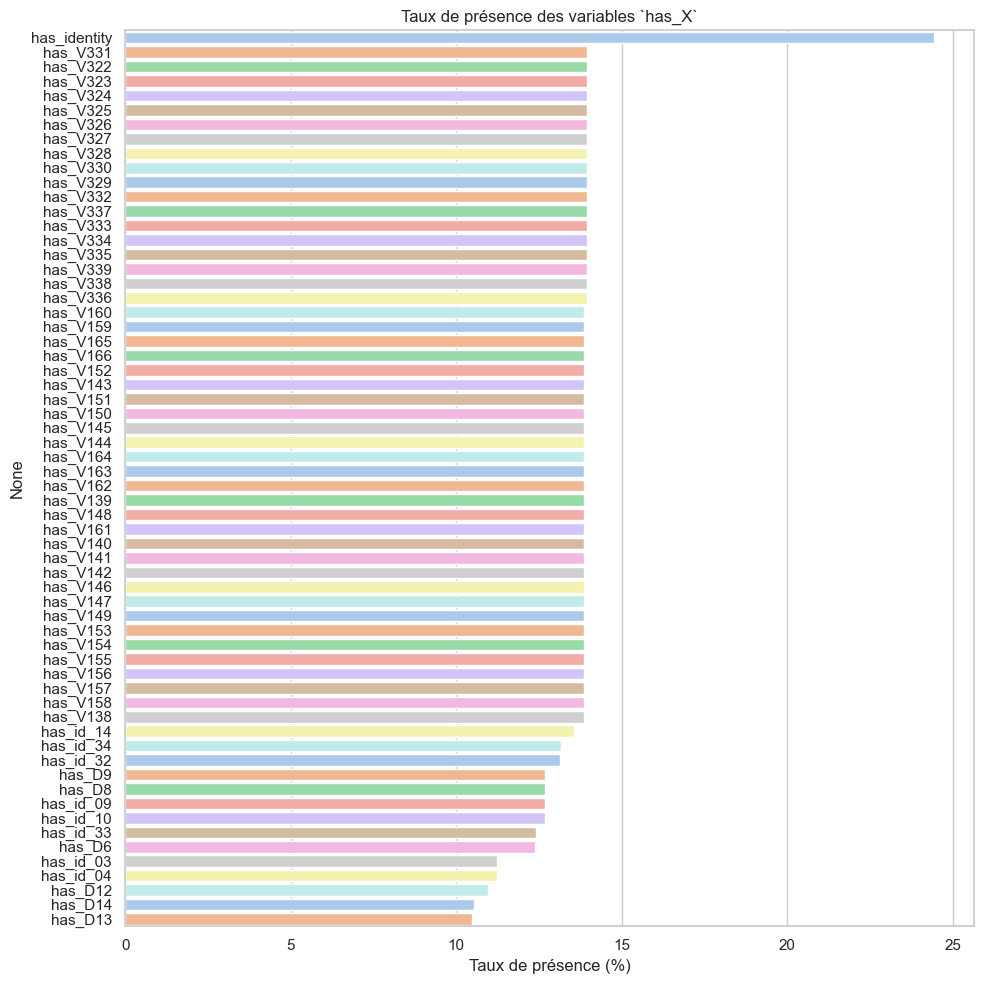

In [ ]:
has_vars = [c for c in df.columns if c.startswith("has_")]

df_sample = df.select(has_vars + ["isFraud"]).toPandas()

# résumé des fréquences pour chaque has_X
presence_rates = df_sample[has_vars].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 10))
sns.barplot(x=presence_rates.values, y=presence_rates.index,hue=presence_rates.index, palette="pastel")
plt.xlabel("Taux de présence(%)")
plt.title("Taux de présence des variables 'has_X'")
plt.tight_layout()
plt.show()

cleanup(df_sample, presence_rates)

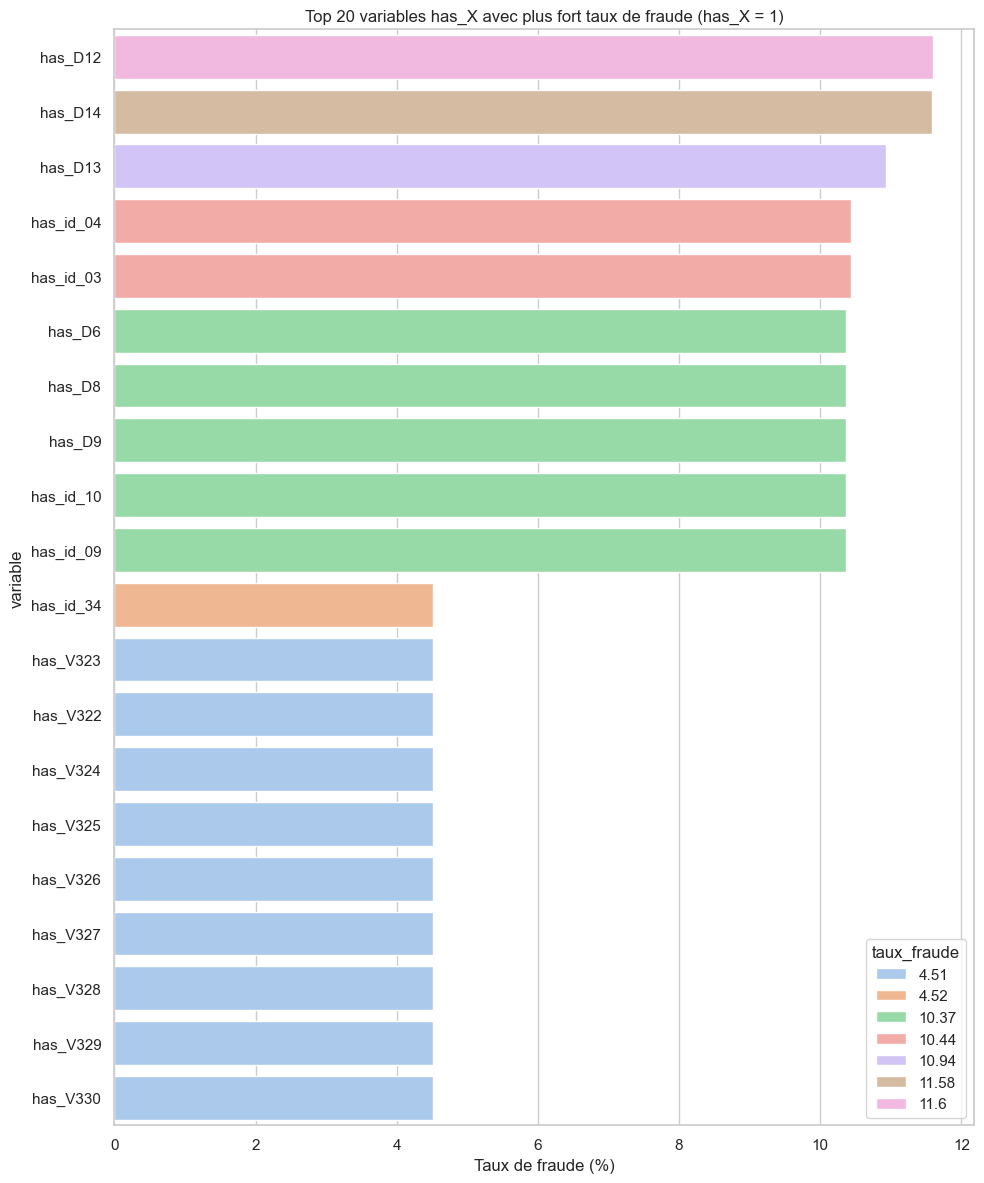

In [ ]:
# liste des colonnes has_X (hors has_identity)
has_vars = [c for c in df.columns if c.startswith("has_") and c != "has_identity"]
df_sample = df.select(has_vars + ["isFraud"]).sample(fraction=0.1).toPandas()

# calcul des taux de fraude pour has_X = 1
resultats = []
for col in has_vars:
    subset = df_sample[df_sample[col] == 1]
    if len(subset) > 0:
        taux = subset["isFraud"].mean() * 100
        resultats.append((col, len(subset), __builtins__.round(taux, 2)))

df_fraude_hasX = pd.DataFrame(resultats, columns=["variable", "n_obs", "taux_fraude"])
df_fraude_hasX = df_fraude_hasX.sort_values("taux_fraude", ascending=False)


plt.figure(figsize=(10, 12))
sns.barplot(data=df_fraude_hasX.head(20), x="taux_fraude", y="variable",hue="taux_fraude", palette="pastel")
plt.title("Top 20 variables has_X avec plus fort taux de fraude (has_X = 1)")
plt.xlabel("Taux de fraude (%)")
plt.tight_layout()
plt.show()
cleanup(df_sample, df_fraude_hasX)

####  Interprétation – Analyse globale des variables `has_X`

L’analyse des variables indicatrices `has_X` montre deux enseignements importants :

-  **Présence dans le dataset** : La plupart des `has_X` sont présentes dans **10 à 25 %** des lignes. Elles permettent donc de **capturer la structure manquante de colonnes partiellement remplies**, sans déséquilibrer le jeu de données.
  - `has_identity` est la plus fréquente (~25 %)
  - Certaines comme `has_D12`, `has_D13`, `has_D14` ou `has_id_03` ont une **faible fréquence (< 15 %)**, ce qui reflète des données rares mais potentiellement très utiles.

-  **Taux de fraude conditionnel (has_X = 1)** : C’est ici que les choses deviennent intéressantes. Plusieurs variables peu fréquentes affichent un **taux de fraude très élevé** :
  - `has_D12` dépasse **11 % de fraude**
  - `has_D13`, `has_D14`, `has_id_04`, `has_D8`, `has_D6` sont toutes **au-dessus de 9 %**
  - À l’inverse, certaines variables très fréquentes comme `has_V138`, `has_V139`, `has_V331` ont des taux proches de la moyenne globale (~3.5 %) → donc peu discriminantes.

Cela confirme un effet classique : **les données les plus rares peuvent contenir les signaux les plus forts**, surtout en détection de fraude.


 En synthèse :
- Nous allons maintenant **approfondir les variables les plus discriminantes**, à savoir :
  - `has_D12`, `has_D14`, `has_id_03`, `has_D8`



### Analyse du lien entre `has_D12` & `has_D14` et la fraude

In [ ]:
# stats globales
stats_d12 = (
    df.groupBy("has_D12", "isFraud")
    .count()
    .groupBy("has_D12")
    .pivot("isFraud", [0, 1])
    .sum("count")
    .fillna(0)
    .withColumn("total", col("0") + col("1"))
    .withColumn("taux_fraude", round(col("1") / col("total") * 100, 2))
    .orderBy("has_D12"))

stats_d12.show()


+-------+------+-----+------+-----------+
|has_D12|     0|    1| total|taux_fraude|
+-------+------+-----+------+-----------+
|      0|512758|13065|525823|       2.48|
|      1| 57119| 7598| 64717|      11.74|
+-------+------+-----+------+-----------+



In [ ]:
### analyse détaillé de la variable 'has_D14'

stats_d14 = ( df.groupBy("has_D14", "isFraud")
    .count()
    .groupBy("has_D14")
    .pivot("isFraud", [0, 1])
    .sum("count")
    .fillna(0)
    .withColumn("total", col("0") + col("1"))
    .withColumn("taux_fraude", round(col("1") / col("total") * 100, 2))
    .orderBy("has_D14"))

stats_d14.show()

+-------+------+-----+------+-----------+
|has_D14|     0|    1| total|taux_fraude|
+-------+------+-----+------+-----------+
|      0|514903|13450|528353|       2.55|
|      1| 54974| 7213| 62187|       11.6|
+-------+------+-----+------+-----------+



###  Interprétation – Variables `has_D12` et `has_D14`

L’analyse des indicateurs `has_D12` et `has_D14` met en évidence des tendances nettes :

- Lorsqu’une **valeur est présente** (`has_D12 = 1` ou `has_D14 = 1`), le **taux de fraude dépasse les 11 %** :
  - `has_D12 = 1` → 11,74 % de fraudes
  - `has_D14 = 1` → 11,60 % de fraudes
- En comparaison, les transactions **sans cette information** (valeurs manquantes) présentent un taux bien plus bas ( = 2,5 %).

Cela confirme que la **présence de certaines variables comportementales**, même sans en connaître la valeur exacte, est **hautement informative** pour détecter la fraude.

 Conclusion :
- Ces deux variables `has_D12` et `has_D14` seront **conservées pour la modélisation**.
- Cette approche **permet d'exploiter l'information issue du "manquant"**, en capturant des signaux faibles souvent négligés.

## 5.4 Analyse des corrélations numériques

####  Objectif : Identifier les variables numériques redondantes ou fortement corrélées

L’objectif de cette section est de :
- Détecter les **corrélations linéaires fortes** entre variables numériques
- **Éviter les redondances** dans les futures étapes de modélisation
- Faciliter une éventuelle **réduction de dimension (ex. : ACP)**


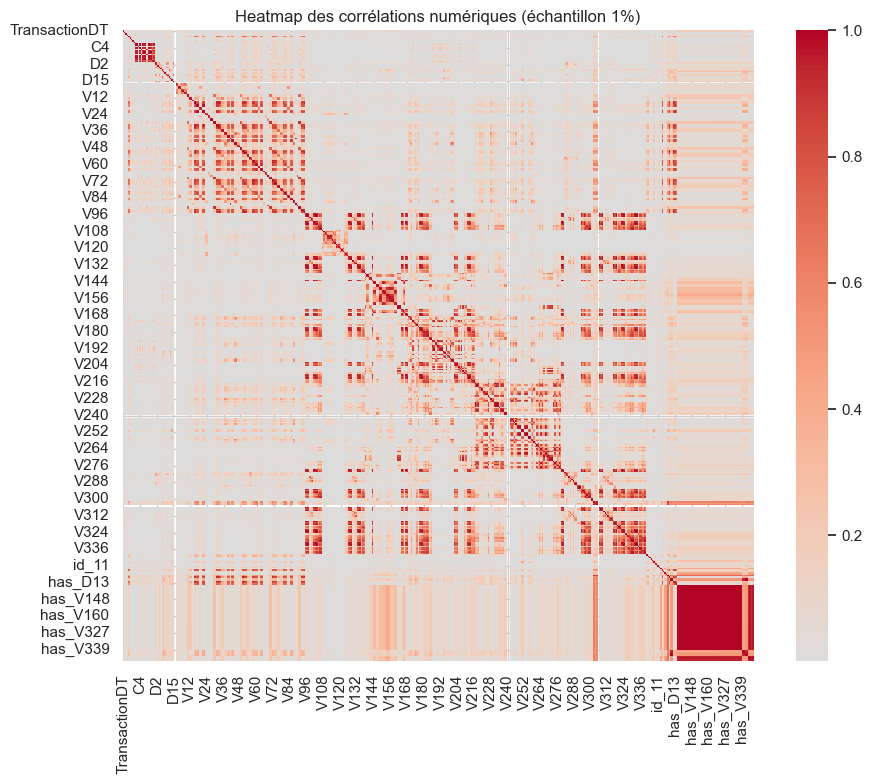

In [ ]:
numeric_cols = [c for c, t in df.dtypes if t in ("double", "int") and c != "isFraud"]

df_sample = df.select(numeric_cols).sample(fraction=0.01).toPandas()

# Calcul du corrélation
corr_matrix = df_sample.corr().abs()

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True)
plt.title("Heatmap des corrélations numériques (échantillon 1%)")
plt.tight_layout()
plt.show()
cleanup(df_sample, corr_matrix)

###  Interprétation – Corrélations numériques

L’analyse des corrélations entre variables numériques (échantillon 1 %) révèle plusieurs éléments clés :

-  **Majoritairement peu de corrélation** entre les variables, ce qui confirme une **diversité d’information utile** pour les modèles.
-  Quelques **blocs fortement corrélés** apparaissent clairement :
  - Notamment au sein des familles de variables `V1xx`, `V3xx`, ou `id_xx`
  - Ces redondances structurelles devront être **prises en compte lors du feature selection ou via une réduction de dimension**
- Certains indicateurs `has_X` sont également corrélés entre eux, ce qui peut signaler :
  - Une dépendance naturelle (ex. : `has_id_03` et `has_id_04`)
  - Ou une origine commune (colonnes dérivées d’un même champ source)

 Implications pour la suite :
- Aucune variable **n’est à supprimer immédiatement** sur base de redondance excessive.
- Un **travail complémentaire de regroupement ou transformation** ( ACP, regroupement de blocs `Vxxx`) pourra être envisagé dans la phase de feature engineering.

Cette cartographie des corrélations **conclut l’EDA approfondie** et servira de base stratégique pour la création de nouvelles features optimisées.

# 6. Feature Engineering

####  Objectif : Créer des variables explicatives pertinentes pour améliorer la détection de fraude

Cette étape consiste à **enrichir et transformer le dataset** afin de renforcer la performance du futur modèle.  
L'objectif est double :

1. **Maximiser la puissance prédictive** des données,
2. **Stabiliser, simplifier et structurer** les variables pour faciliter l’apprentissage machine.

---

Nous allons structurer cette phase en **trois sous-étapes complémentaires** :

1. **Feature Construction**  
   Création de nouvelles variables à partir de la logique métier et des patterns identifiés lors de l’EDA :
   - Flags : `is_high_amount`, `is_recent_activity`, `is_weekend`, `is_credit_card`, etc.
   - Combinaisons : `card4_card6`
   - Présence de données : `has_identity`, `has_X`
   - Ratios comportementaux : `C1_sur_D1`

2. **Transformation, Scaling & Encodage**  
  Préparation des données numériques et catégorielles :   
   - **Log-transform** des variables asymétriques (`TransactionAmt`, `D1`, etc.)
   - **StandardScaler** après log-transform sur les variables continues
   - **Encodage** des variables catégorielles (`StringIndexer` + `OneHotEncoder`)

3. **Finalisation du dataset**  
   - Assemblage final des features (VectorAssembler)
   - Nettoyage et suppression des colonnes redondantes
   - Préparation du jeu de test avant modélisation



## 6.1 Feature Construction

####  Objectif : Enrichir le dataset avec des indicateurs binaires et dérivés simples

Cette étape vise à ajouter des variables dérivées directement issues de l’intuition métier et de l’analyse exploratoire.  
Ces features permettent de capturer des comportements spécifiques sans complexité excessive.

####  Features déjà présentes (issues des étapes précédentes) :
- `has_identity` : identifie les transactions enrichies via le fichier d’identité (créée lors de l’EDA brut)
- `has_X` : série de variables binaires (créées au nettoyage) capturant la présence d’information dans des colonnes incomplètes (`has_D12`, `has_V138`, etc.)

####  Nouvelles features ajoutées ici :

- `is_recent_activity` : identifie des comptes ou comportements très récents (`D1 == 0`)
- `is_high_amount` : détecte les montants de transaction très élevés (`TransactionAmt > 1000`)
- `is_product_C` : flag pour le produit le plus frauduleux (`ProductCD == "C"`)
- `is_credit_card` : type de carte utilisé (`card6 == "credit"`)
- `is_discover_card` : réseau de carte à haut risque (`card4 == "discover"`)
- `card4_card6` : combinaison des deux types de carte
- `day`, `is_weekend` : dérivées temporelles à partir de `TransactionDT`

In [ ]:
# 1. Activité récente (D1)
df = df.withColumn("is_recent_activity", (col("D1") == 0).cast("int"))

# 2. Montant élevé
df = df.withColumn("is_high_amount", (col("TransactionAmt") > 1000).cast("int"))

# 3.Produit spécifique
df = df.withColumn("is_product_C", (col("ProductCD") == "C").cast("int"))

# 4. Type de carte
df = df.withColumn("is_credit_card", (col("card6") == "credit").cast("int"))

# 5. Réseau de carte Discover
df = df.withColumn("is_discover_card", (col("card4") == "discover").cast("int"))

# 6. Combinaison card4 + card6
df = df.withColumn("card4_card6", concat_ws("_", col("card4"), col("card6")))

# 7. Date en jours (TransactionDT)
df = df.withColumn("day", (col("TransactionDT") / 86400).cast("int"))

# 8. Week-end
df = df.withColumn("is_weekend", expr("int((day % 7) IN (5, 6))"))

# 9.Ratio comportemental C1 / D1
df = df.withColumn("C1_sur_D1", when(col("D1") == 0, col("C1")).otherwise(col("C1") / (col("D1") + 1e-4)))

In [ ]:
### --======= Variable crée après une premiere Modélisation effectuer =======- ###  

df = df.withColumn("is_email_mismatch", (col("P_emaildomain") != col("R_emaildomain")).cast("int"))

# frréquence d'utilisation de la même carte
df = df.withColumn("card_id", concat_ws("_", col("card1"), col("card2"), col("card3"), col("card5")))
df = df.withColumn("card_id_length", length(col("card_id")))

    # Ratios sur délais et montants
df = df.withColumn("log1p_D15", log1p(col("D15")))
df = df.withColumn("Amt_sur_D15", col("log1p_TransactionAmt") / (col("D15") + 1e-3))
df = df.withColumn("log1p_Amt_sur_D15", log1p(col("Amt_sur_D15")))
df = df.withColumn("log1p_D15", when(col("log1p_D15").isNull(), 0.0).otherwise(col("log1p_D15")))
df = df.withColumn("log1p_Amt_sur_D15", when(col("log1p_Amt_sur_D15").isNull(), 0.0).otherwise(col("log1p_Amt_sur_D15")))

# indicateur d’absence de délai
df = df.withColumn("is_missing_D15", (col("D15").isNull() | isnan(col("D15"))).cast("int"))

###   Analyse des variables binaires construites

Nous analysons ici les variables binaires créées , l’objectif est d’évaluer leur **pouvoir discriminant** à travers deux axes :

- **Le taux de fraude** associé à la valeur 1,
- **La fréquence d’apparition** de cette modalité dans le dataset.

Nous utilisons un échantillon aléatoire pour alléger le traitement et visualiser les tendances globales.

In [ ]:
def plot_fraud_vs_freq(df, vars_binaires, sample_frac=0.05):
    
    df_sample = df.select(vars_binaires + ["isFraud"]).sample(fraction=sample_frac).toPandas()

    # calculs taux de fraude et fréquence
    data = []
    for var in vars_binaires:
        if var in df_sample.columns:
            subset = df_sample[df_sample[var] == 1]
            if len(subset) > 0:
                data.append({
                    "variable": var,
                    "taux_fraude": subset["isFraud"].mean() * 100,
                    "frequence": df_sample[var].mean() * 100
                })

    df_plot = pd.DataFrame(data).sort_values("taux_fraude", ascending=False)

    fig, ax1 = plt.subplots(figsize=(7, 5))
    sns.barplot(data=df_plot, y="variable", x="taux_fraude", color="salmon", ax=ax1)
    ax1.set_xlabel("Taux de fraude (%)")
    ax1.set_ylabel("Variable")

    ax2 = ax1.twiny()
    ax2.plot(df_plot["frequence"], df_plot["variable"], "o-", color="steelblue", label="Fréquence (%)")
    ax2.set_xlim(0, df_plot["frequence"].max() * 1.2)
    ax2.set_xlabel("Fréquence (%)")
    ax2.legend(loc="lower right")

    plt.title("Taux de fraude vs fréquence des variables binaires")
    plt.tight_layout()
    plt.show()

    cleanup(df_sample, df_plot)


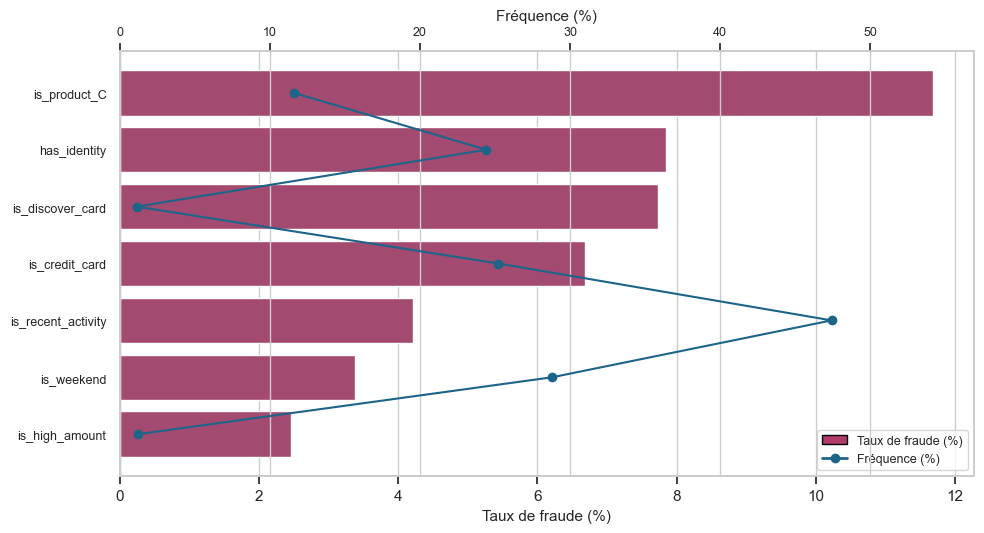

In [ ]:
vars_bin = ["is_recent_activity", "is_product_C", "is_high_amount", "is_discover_card", "is_credit_card",
            "has_identity", "is_weekend"]

plot_fraud_vs_freq(df, vars_bin)

### Analyse exploratoire de la variable catégorielle `card4_card6`

La variable `card4_card6` est une **combinaison de deux colonnes catégorielles** (`card4` et `card6`) représentant respectivement :
- Le **réseau de carte bancaire** (`visa`, `mastercard`, `discover`, etc.)
- Le **type de carte** (`credit`, `debit`, `charge card`, etc.)

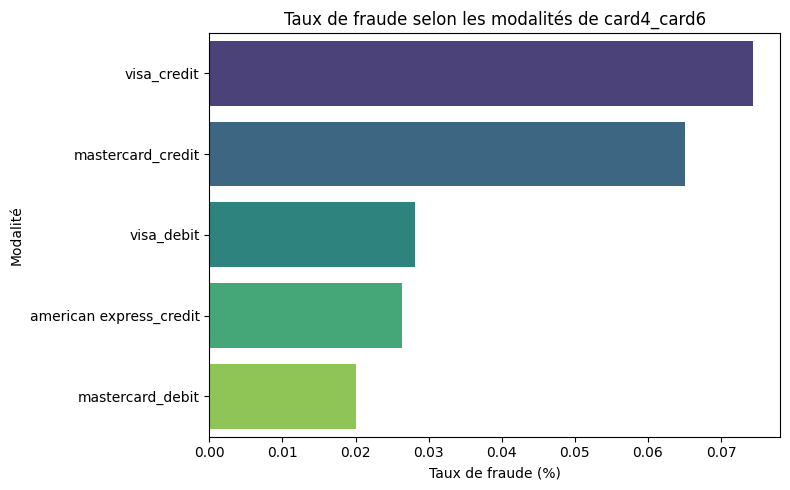

In [ ]:
df_sample = df.select("card4_card6", "isFraud").dropna().sample(fraction=0.05).toPandas()

# taux de fraude + fréquence
stats = df_sample.groupby("card4_card6")["isFraud"].agg(["mean", "count"]).reset_index()
stats.columns = ["card4_card6", "taux_fraude", "frequence"]

# Filtrage fréquence (>= 1%)
stats["frequence_pct"] = stats["frequence"] / stats["frequence"].sum()
stats_filtrées = stats[stats["frequence_pct"] >= 0.01].sort_values("taux_fraude", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=stats_filtrées, y="card4_card6", x="taux_fraude",hue="card4_card6" ,palette="viridis")
plt.title("Taux de fraude selon les modalités de card4_card6")
plt.xlabel("Taux de fraude (%)")
plt.ylabel("Modalité")
plt.tight_layout()
plt.show()
cleanup(df_sample, stats, stats_filtrées)   

####  Interprétation – `card4_card6`

`card4_card6` combine le type (`card6`) et le réseau de carte (`card4`).  
L’analyse montre que certaines modalités comme `visa_credit` et `mastercard_credit` présentent des **taux de fraude élevés** (> 7 % et ~6.5 %).

En revanche, des combinaisons comme `mastercard_debit` sont **plus fréquentes mais moins risquées** (~2 %).

Ces différences justifient la conservation de cette variable, qui sera **encodée (StringIndexer + OneHotEncoder)**. Les modalités rares seront regroupées ou exclues si nécessaire.


## 6.2 Transformation, Scaling & Encodage

####  Objectif : Adapter les variables existantes pour les rendre compatibles avec les algorithmes de machine learning

Cette étape vise à :
- **Stabiliser** les distributions asymétriques via des transformations log (`log1p`)
- **Uniformiser les échelles** des variables continues grâce au **scaling**
- **Encoder** efficacement les variables catégorielles avec `OneHotEncoding`

###  Log-transformations & feature combinée

On applique une transformation logarithmique `log1p(x)` sur les variables fortement asymétriques pour :
- Réduire l’effet des valeurs extrêmes
- Rendre les distributions plus symétriques

In [13]:
# fortement asymétriques vu en EDA 
cols_log = ["TransactionAmt", "C1_sur_D1", "D1"]

for col_name in cols_log:
    df = df.withColumn(f"log1p_{col_name}", log1p(col(col_name)))


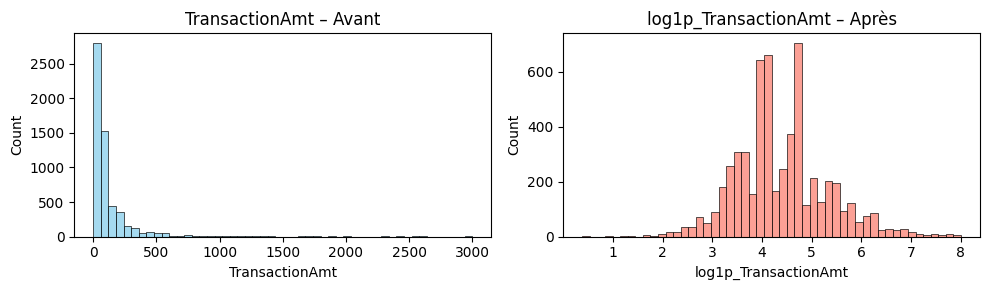

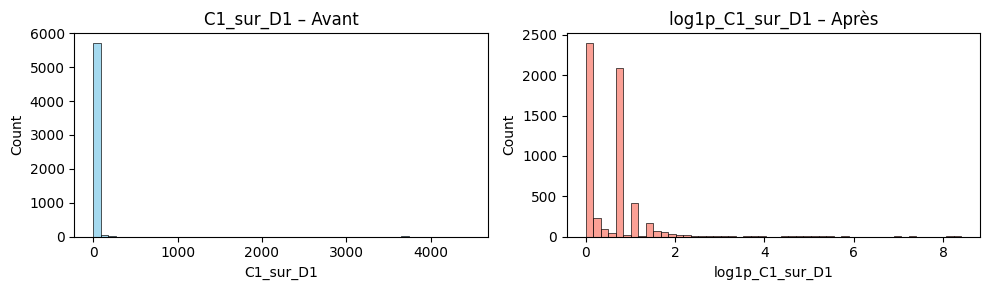

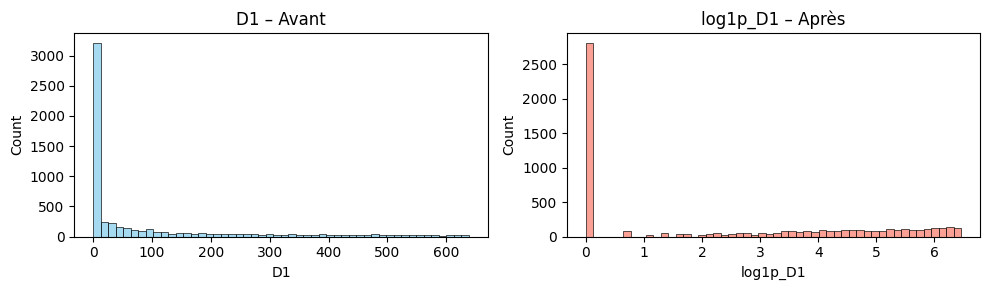

In [ ]:
# échantillon allégé
df_sample = df.select(["TransactionAmt", "log1p_TransactionAmt",
                       "C1_sur_D1", "log1p_C1_sur_D1",
                       "D1", "log1p_D1"]).sample(fraction=0.01).toPandas()

# Colonnes à comparer
features = [("TransactionAmt", "log1p_TransactionAmt"),
            ("C1_sur_D1", "log1p_C1_sur_D1"),
            ("D1", "log1p_D1")]

for orig, loged in features:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.histplot(df_sample[orig], bins=50, ax=axes[0], kde=False, color="skyblue")
    axes[0].set_title(f"{orig} – Avant")

    sns.histplot(df_sample[loged], bins=50, ax=axes[1], kde=False, color="salmon")
    axes[1].set_title(f"{loged} – Après")

    plt.tight_layout()
    plt.show()

cleanup(df_sample)


#### Hypothèse métier – 

Malgré la transformation `log1p`, la variable `C1_sur_D1` reste très concentrée sur les faibles valeurs, ce qui reflète bien la nature de la fraude :  
les fraudeurs agissent souvent de manière **très intense sur un laps de temps très court**.

Or, nous disposons déjà de la variable binaire `is_recent_activity`, qui capte le fait que `D1 == 0`, soit **une activité récente ou immédiate**.


#### l'Idée : combiner ces deux informations

Nous disposons déjà de :

- `is_recent_activity` : indique si l'activité est immédiate (`D1 == 0`)
- `log1p_C1_sur_D1` : mesure l’intensité du comportement

 Nous combinons ces deux informations dans une **nouvelle variable binaire** `is_recent_intense` :


In [ ]:
df = df.withColumn( "is_recent_intense",
    ((col("log1p_C1_sur_D1") > 2.5) & (col("is_recent_activity") == 1)).cast("int"))

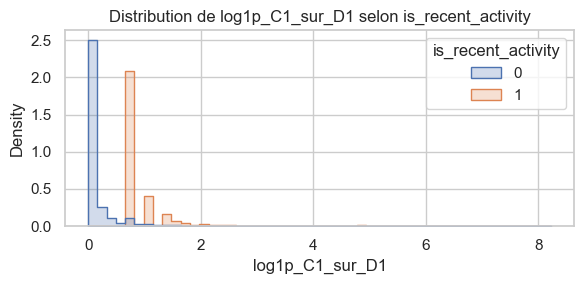

In [ ]:
df_sample = df.select("log1p_C1_sur_D1", "is_recent_activity").sample(fraction=0.01).toPandas()

plt.figure(figsize=(6, 3))
sns.histplot(data=df_sample, x="log1p_C1_sur_D1", hue="is_recent_activity", bins=50, element="step", stat="density")
plt.title("Distribution de log1p_C1_sur_D1 selon is_recent_activity")
plt.xlabel("log1p_C1_sur_D1")
plt.tight_layout()
plt.show()

cleanup(df_sample)

In [ ]:
df.groupBy("is_recent_intense").agg(
    count("*").alias("n_obs"),
    round(mean("isFraud") * 100, 2).alias("taux_fraude_%")
).orderBy("is_recent_intense").show()

+-----------------+------+-------------+
|is_recent_intense| n_obs|taux_fraude_%|
+-----------------+------+-------------+
|                0|581580|          3.2|
|                1|  8960|         23.2|
+-----------------+------+-------------+



#### Interprétation – `is_recent_intense` vs `isFraud`

- Le **taux de fraude atteint 23.2 %** parmi les cas où `is_recent_intense = 1`  
- Contre seulement **3.2 %** lorsque la variable vaut 0  
- Cela confirme que cette **feature combinée est hautement informative**, bien plus que `D1` ou `C1` pris isolément

Conclusion :
- `is_recent_intense` est un **signal comportemental fort**, capturant des fraudes rapides et intenses
- Elle sera **conservée pour la modélisation**, et priorisée dans les sélections de features

In [ ]:
#df = df.drop( "C1_sur_D1","D1","TransactionAmt")

###  Mise à l’échelle & Encodage des variables

 Objectif : Préparer les variables pour une utilisation efficace avec les modèles de machine learning, qui sont souvent sensibles :

-   à l’échelle des variables numériques (ex. KNN, SVM, réseaux de neurones)
-   à la représentation des variables catégorielles (arbres, régressions…)

####  Standardisation des variables numériques

Certaines variables numériques présentent des échelles très différentes (ex. montants en dollars, jours, identifiants, etc.). Cela peut nuire à certains algorithmes sensibles à l’échelle comme la régression logistique, le k-means, ou encore les modèles linéaires.

Pour y remédier, nous appliquons une standardisation (via `StandardScaler`) sur les **variables numériques continues**, c’est-à-dire :

- qui sont de type numérique (`int`, `double`)
- qui possèdent un **nombre suffisant de modalités** (ex. > 10) pour éviter les colonnes quasi-binaires
- en excluant les colonnes binaires (`is_`, `has_`, etc.) ou déjà encodées (`OneHot`, `index`)

Le `StandardScaler` transforme chaque variable pour qu’elle ait :
- une **moyenne centrée à 0**
- un **écart-type de 1**

Cela permet de rendre les variables comparables et de **faciliter l'apprentissage des modèles**.

Les colonnes contenant des valeurs manquantes (`null`) ont été retirées avant transformation pour éviter les erreurs lors du `fit()`.

In [21]:
# détecter les colonnes numériques continues 
def detect_continuous_columns(df, seuil_unique=10):
    numeric_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ["double", "int"]]
    continuous_cols = []
    for col_name in numeric_cols:
        unique_count = df.select(col_name).na.drop().distinct().count()
        if unique_count > seuil_unique:
            continuous_cols.append(col_name)
    return continuous_cols

# exclusions (binaires, cibles, encodées, etc.)
exclusions = ["isFraud"] + [c for c in df.columns if "is_" in c or "has_" in c or "OneHot" in c or "index" in c]
cols_to_scale = [c for c in detect_continuous_columns(df) if c not in exclusions]

# VectorAssembler
assembler = VectorAssembler(inputCols=cols_to_scale, outputCol="features_to_scale")
df = assembler.transform(df)

# tandardScaler directement sur df
scaler = StandardScaler(inputCol="features_to_scale", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


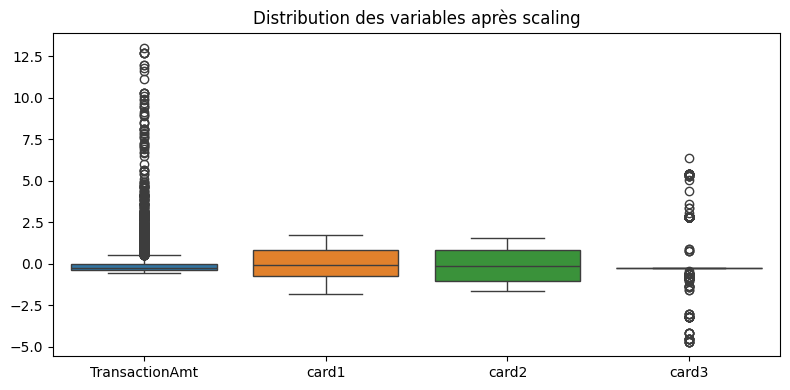

In [ ]:
df = df.withColumn("scaled_array", vector_to_array("scaled_features"))

df_sample = df.select("scaled_array").limit(10000).toPandas()
scaled_df = pd.DataFrame(df_sample["scaled_array"].tolist(), columns=cols_to_scale)

plt.figure(figsize=(8, 4))
sns.boxplot(data=scaled_df[cols_to_scale[1:5]])  # montre les 5 premières variables scalé
plt.title("Distribution des variables après scaling")
plt.tight_layout()
plt.show()
cleanup(df_sample, scaled_df)

### OneHot Encoding des variables catégorielles

Les modèles de machine learning ne peuvent pas exploiter directement les variables catégorielles sous forme de chaînes (`string`). Il est donc nécessaire de les encoder en variables numériques.

Nous utilisons ici un **OneHot Encoding**, qui transforme chaque modalité en une colonne binaire (`0` ou `1`). Cela permet de :

- préserver l'information sans introduire de hiérarchie arbitraire (contrairement au `StringIndexer` seul)
- éviter que le modèle interprète un ordre entre les catégories

####  Étapes de l'encodage

1. **Sélection des variables catégorielles** :
    - détecter les colonnes de type `string` 
    - conservation uniquement des variables :
        - à **signal significatif** (fort écart de taux de fraude)
        - à **modalité raisonnable**
    - exclusion manuelle des colonnes :
        - à **forte cardinalité (> 100 modalités)** → explosion dimensionnelle
        - à **faible pouvoir discriminant** (écart de taux de fraude faible)

2. **Encodage** :
   - `StringIndexer`: pour convertir les chaînes en indices numériques
   - `OneHotEncoder`: pour transformer ces indices en vecteurs binaires


In [ ]:
df_types = spark.createDataFrame(df.dtypes, ["column", "type"])
df_types.groupBy("type").count().orderBy("count", ascending=False).show()

# liste des colonnes catégorielle
cat_cols = [c for c, t in df.dtypes if t == "string"]

+-------------+-----+
|         type|count|
+-------------+-----+
|       double|  393|
|          int|   73|
|       string|   29|
|       vector|    2|
|array<double>|    1|
+-------------+-----+



In [ ]:
total_rows = df.count()
results = []

for var in cat_cols:
    try:
        # GroupBy unique pour tout faire en un seul passage
        stats_df = (
            df.groupBy(var)
              .agg(
                  count("*").alias("cnt"),
                  spark_round(avg("isFraud") * 100, 2).alias("fraud_rate")))

        # Récup stats globales
        stats = stats_df.agg(
            spark_round(expr(f"max(cnt) / {total_rows} * 100"), 2).alias("max_freq"),
            expr("min(fraud_rate)").alias("min_fraud"),
            expr("max(fraud_rate)").alias("max_fraud")).first()

        # Nbs de modalités avec distinct.count()
        n_modalites = df.select(var).distinct().count()

        results.append({
            "variable": var,
            "n_modalites": n_modalites,
            "max_freq_%": stats["max_freq"],
            "fraude_min_%": stats["min_fraud"],
            "fraude_max_%": stats["max_fraud"]
            })
    except Exception as e:
        print(f"Erreur {var}: {e}")

df_cat_analysis = pd.DataFrame(results).sort_values("n_modalites", ascending=False)
df_cat_analysis.head(30)


,variable,n_modalites,max_freq_%,fraude_min_%,fraude_max_%
21,id_33,261,87.59,0.00,100.00
20,id_31,131,76.25,0.00,100.00
19,id_30,76,86.87,0.00,60.00
4,R_emaildomain,61,76.75,0.00,95.12
3,P_emaildomain,60,38.67,0.00,40.79
28,card4_card6,15,50.97,0.00,33.33
1,card4,5,65.16,2.60,7.73
22,id_34,5,86.82,0.00,6.37
0,ProductCD,5,74.45,2.04,11.69
2,card6,5,74.50,0.00,6.68


In [ ]:
### === Création de colonnes combinée après la première modélisation ===- ###
df = df.withColumn("M789_combo", concat_ws("_", col("M7"), col("M8"), col("M9")))

In [ ]:
cols_to_remove = [ 
    "id_30", "id_31", "id_33",  # Haute cardinalité
    "M7", "M8", "M9" ]           # Faible signal 

#### Sélection des variables catégorielles à encoder

L’analyse croisée de la **cardinalité des modalités** et de leur **pouvoir discriminant** (écart de taux de fraude entre les modalités) permet d’identifier les variables catégorielles les plus utiles.

**Variables retenues pour encodage (`OneHotEncoding`)** :
- `ProductCD`, `card4`, `card6` : types de produits et réseaux bancaires
- `P_emaildomain`, `R_emaildomain` : domaine d’email utilisateur (signal fort)
- `DeviceType`, `M4` : caractéristiques comportementales
- `card4_card6` : combinaison créée, informative
- `id_15`, `id_16`, `id_28`, `id_29`, `id_35`, `id_36`, `id_37`, `id_38` : variables d'identité à faible cardinalité avec signal intéressant

**Variables exclues** :
- `id_30`, `id_31`, `id_33` : trop grande cardinalité (> 100 modalités), risque de **sur-apprentissage**
- `M7`, `M8`, `M9` : peu de différenciation en termes de fraude, **signal faible**

**Variables en attente d’évaluation** :
- `M1`, `M2`,`M6`... etc. seront réévaluées lors de la **sélection de features** (via LightGBM, SHAP)

Cette sélection permet de **réduire la complexité**, d’**améliorer la lisibilité** du modèle et de garantir une **meilleure performance générale**.

### Encodage des variables catégorielles retenues

In [23]:
vars_to_encode = [ "ProductCD", "card4", "card6",
    # "P_emaildomain", "R_emaildomain", "card4_card6", "M789_combo" ,
    "DeviceType", "M4", 
    "id_15", "id_16", "id_28", "id_29",
    "id_35", "id_36", "id_37", "id_38",
    # Vars à évaluer ensuite avec importance/ shap
    "M1", "M2", "M3", "M5", "M6",
    "id_12", "id_34"]

In [ ]:
###  pipeline d’encodage : StringIndexer + OneHotEncoder

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") for col in vars_to_encode]

# OnehotEncoding
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in vars_to_encode]


pipeline = Pipeline(stages=indexers + encoders)

encoding_pipeline_model = pipeline.fit(df)
# df du pipeline à transformer
df = encoding_pipeline_model.transform(df)

# suppression des colonnes d’origine 
# df = df.drop(*vars_to_encode)

#### Frequency encoding 

In [25]:

# === Freq encoding == 
vars_to_frequency_encode = [
    "P_emaildomain", "R_emaildomain",
    "card4_card6", "M789_combo" ,"id_30", "id_31"
     #"card_id"                        
]

def frequency_encode(df, colname):
    freq_df = df.groupBy(colname).agg(count("*").alias("cnt"))
    total_count = df.count()
    freq_df = freq_df.withColumn(f"{colname}_freq", col("cnt") / total_count).drop("cnt")
    return df.join(freq_df, on=colname, how="left")

for colname in vars_to_frequency_encode:
    if colname in df.columns:
        df = frequency_encode(df, colname)
    else:
        print(f" Colonne {colname} absente ou déjà supprimée — vérifie ta logique.")

#df = df.drop(*[col for col in vars_to_frequency_encode if col in df.columns])


#### Target Encoding 

In [ ]:

vars_to_target_encode = [
    "P_emaildomain", "R_emaildomain"
]

target_col = "isFraud"  

def target_encode(df, colname, target):
    target_enc_df = df.groupBy(colname).agg(mean(target).alias(f"{colname}_target_enc"))
    return df.join(target_enc_df, on=colname, how="left")

for colname in vars_to_target_encode:
    if colname in df.columns:
        df = target_encode(df, colname, target_col)
    else:
        print(f"Colonne {colname} absente ou déjà supprimée — vérifie ta logique.")

# df = df.drop(*[col for col in vars_to_target_encode if col in df.columns])


In [ ]:
# listes encodées
encoded_cols = [f"{col}_vec" for col in vars_to_encode]

df.select(encoded_cols).printSchema()

root
 |-- ProductCD_vec: vector (nullable = true)
 |-- card4_vec: vector (nullable = true)
 |-- card6_vec: vector (nullable = true)
 |-- P_emaildomain_vec: vector (nullable = true)
 |-- R_emaildomain_vec: vector (nullable = true)
 |-- DeviceType_vec: vector (nullable = true)
 |-- M4_vec: vector (nullable = true)
 |-- card4_card6_vec: vector (nullable = true)
 |-- id_15_vec: vector (nullable = true)
 |-- id_16_vec: vector (nullable = true)
 |-- id_28_vec: vector (nullable = true)
 |-- id_29_vec: vector (nullable = true)
 |-- id_35_vec: vector (nullable = true)
 |-- id_36_vec: vector (nullable = true)
 |-- id_37_vec: vector (nullable = true)
 |-- id_38_vec: vector (nullable = true)
 |-- M1_vec: vector (nullable = true)
 |-- M2_vec: vector (nullable = true)
 |-- M3_vec: vector (nullable = true)
 |-- M5_vec: vector (nullable = true)
 |-- M6_vec: vector (nullable = true)
 |-- id_12_vec: vector (nullable = true)
 |-- id_34_vec: vector (nullable = true)



#### Interprétation - Encodage des variables catégorielles 

Les variables catégorielles sélectionnées (`ProductCD`, `card4`, `id_38`, etc.) ont été encodées via un **pipeline Spark** combinant :

- `StringIndexer` → convertit les modalités en indices numériques.
- `OneHotEncoder` → transforme ces indices en vecteurs binaires (`xxx_vec`).

 Exemple : `card6 == "credit"` devient un vecteur sparse `(5,[1],[1.0])`.

Les colonnes d’origine (`string`) sont supprimées après transformation pour ne conserver que les vecteurs encodés.

Résultat :
- Un ensemble de colonnes numériques `xxx_vec` prêtes pour la modélisation.
- Structure adaptée aux modèles linéaires, arbres, ou réseaux de neurones.

## 6.3 Finalisation du dataset

####  Objectif : Obtenir un jeu de données complet, propre et entièrement numérique, prêt pour la modélisation

Cette étape consiste à assembler toutes les features finales dans un vecteur unique et à supprimer les colonnes obsolètes ou redondantes.


In [ ]:

# étape finale — regrouper toutes les features utiles
final_features = [c for c in df.columns 
                  if c.endswith("_vec") 
                  #or c.endswith("_target_enc") 
                  or c.endswith("_freq")       # encodage de fréquence
                  or c.startswith("is_")        # indicateurs binaires
                  or c.startswith("has_")       # présence de données
                  or c.startswith("log1p_")
                  or c.startswith("fp_")        # variables log-transformée
                  or c == "scaled_features"]     # vecteur des features continues scalée

# Assemblage final dans un seul vecteur 'features'
assembler = VectorAssembler(inputCols=final_features, outputCol="features")
df_final = assembler.transform(df)

# Vérification finale
df_final.select("features", "isFraud").show(3, truncate=20)


+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[0.0,0.0,0.0,0.0,...|      0|
|[0.0,0.0,0.0,0.0,...|      0|
|[0.0,0.0,0.0,0.0,...|      0|
+--------------------+-------+
only showing top 3 rows



In [28]:
# Calcul et ajout de poids de classe (pour gerer le déséquilibre)
total = df_final.count()
nb_fraudes = df_final.filter(col("isFraud") == 1).count()
nb_nonfraudes = total - nb_fraudes
fraud_weight = nb_nonfraudes / nb_fraudes

df_final = df_final.withColumn("classWeight", when(col("isFraud") == 1, fraud_weight).otherwise(1.0))

In [30]:
df_final.write.mode("overwrite").parquet("data/df_final_v5.parquet")

In [31]:
df_final_clean = df_final.select("features", "isFraud", "classWeight")
df_final_clean.write.mode("overwrite").parquet("data/df_final_Vsimple5.parquet")

In [ ]:
df_final.write.mode("overwrite").parquet("data/df_final.parquet")

# 7. Modélisation supervisée

 **Objectif** : Entraîner des modèles supervisés pour détecter les fraudes à partir des variables préparées.


####  Données d’entrée

Nous disposons de :

- `df_final` : dataset complet pour l'entraînement
  - `features` : vecteur de variables explicatives (transformées, encodées, assemblées)
  - `isFraud` : variable cible binaire (fraude ou non)

- `test_df` : jeu de test transformé à l’identique, prêt pour les prédictions



###  7.1 Split du jeu d’entraînement (stratifié)

On sépare `df_final` en un ensemble **train** et un ensemble **validation** :

In [3]:
df_final = spark.read.parquet("data/df_final_freq.parquet")

In [3]:
df_final = spark.read.parquet("data/df_final_freq1.parquet")

In [ ]:
df_final = spark.read.parquet("data/df_final_v5.parquet")

In [ ]:
df_final = spark.read.parquet("data/df_final_Vsimple5.parquet")

In [7]:
train_df, valid_df = df_final.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_df.count()} rows, Valid: {valid_df.count()} rows")

Train: 472460 rows, Valid: 118080 rows


In [ ]:
for name, df in [("train", train_df), ("valid", valid_df), ("global", df_final)]:
		total = df.count()
		n_fraudes = df.filter("isFraud == 1").count()
		print(f"{name} : taux de fraude = {n_fraudes / total:.4f}")

train : taux de fraude = 0.0350
valid : taux de fraude = 0.0349
global : taux de fraude = 0.0350


###  7.2 - Entraînement des modèles

Dans cette étape, nous entraînons plusieurs modèles de classification pour comparer leurs performances :

- `LogisticRegression` : modèle de base, simple et interprétable.
- `RandomForestClassifier` : ensemble d’arbres de décision, robuste et performant.
- `GBTClassifier` : Gradient Boosted Trees, souvent très efficace sur les données déséquilibrées.

In [5]:
models = [ 
    ("LogisticRegression", LogisticRegression(featuresCol="features", labelCol="isFraud", weightCol="classWeight", maxIter=20)),
    ("RandomForest", RandomForestClassifier(featuresCol="features", labelCol="isFraud", weightCol="classWeight", numTrees=100)),
    ("GBT", GBTClassifier(featuresCol="features", labelCol="isFraud", weightCol="classWeight", maxIter=50))]

trained_models = {}
predictions = {}

# Entraînement et prédictions
for name, model in models:
    print(f"Entraînement du modèle {name}")
    fitted = model.fit(train_df)
    preds = fitted.transform(valid_df)
    
    # Extraire la probabilité de la classe 1
    preds = preds.withColumn("proba_array", vector_to_array("probability"))
    preds = preds.withColumn("proba_1", col("proba_array")[1])
    
    trained_models[name] = fitted
    predictions[name] = preds

Entraînement du modèle LogisticRegression
Entraînement du modèle RandomForest
Entraînement du modèle GBT


### 7.3 — Évaluation des modèles 

 Objectif : Comparer objectivement les performances de chaque modèle sur le jeu de validation.

Nous utilisons plusieurs métriques :

- **AUC (Area Under Curve ROC)** : capacité du modèle à distinguer fraudes et non-fraudes
- **F1-score** : équilibre entre précision et rappel
- **Accuracy** : taux global de bonnes prédictions
- **Précision** : parmi les alertes de fraude, combien sont vraiment des fraudes ?
- **Recall** : parmi les fraudes réelles, combien sont détectées ?

In [6]:
evaluator_auc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")
results = []

for name, preds in predictions.items():
    print(f"Évaluation du modèle {name}")

    sample = preds.sample(fraction=0.2, seed=42).cache()
    sample.count()  
    
    # Prédiction avec seuil custom
    sample = sample.withColumn("custom_prediction", when(col("proba_1") > 0.4, 1).otherwise(0))

    # TP / FP / FN / TN
    TP = sample.filter((col("custom_prediction") == 1) & (col("isFraud") == 1)).count()
    FP = sample.filter((col("custom_prediction") == 1) & (col("isFraud") == 0)).count()
    FN = sample.filter((col("custom_prediction") == 0) & (col("isFraud") == 1)).count()
    TN = sample.filter((col("custom_prediction") == 0) & (col("isFraud") == 0)).count()

    # Métriques
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-6)
    auc = evaluator_auc.evaluate(sample)

    results.append({
        "Model": name,
        "AUC": auc,
        "F1": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Dataset": "valid"})

# Résultats finaux
results_df = pd.DataFrame(results)
display(results_df)

Évaluation du modèle LogisticRegression
Évaluation du modèle RandomForest
Évaluation du modèle GBT


,Model,AUC,F1,Accuracy,Precision,Recall,Dataset
0,LogisticRegression,0.871522,0.179575,0.736864,0.100559,0.838235,valid
1,RandomForest,0.854481,0.172561,0.731096,0.096480,0.816176,valid
2,GBT,0.915771,0.237849,0.813826,0.138387,0.845588,valid


In [8]:
for name, fitted in trained_models.items():
    print(f"Évaluation du modèle {name} (TRAINING)")

    preds_train = fitted.transform(train_df)
    
    preds_train = preds_train.withColumn("proba_array", vector_to_array("probability")) \
                             .withColumn("proba_1", col("proba_array")[1]) \
                             .withColumn("custom_prediction", when(col("proba_1") > 0.4, 1).otherwise(0))
    
    sample_train = preds_train.sample(fraction=0.2, seed=42).cache()
    sample_train.count()

    TP = sample_train.filter((col("custom_prediction") == 1) & (col("isFraud") == 1)).count()
    FP = sample_train.filter((col("custom_prediction") == 1) & (col("isFraud") == 0)).count()
    FN = sample_train.filter((col("custom_prediction") == 0) & (col("isFraud") == 1)).count()
    TN = sample_train.filter((col("custom_prediction") == 0) & (col("isFraud") == 0)).count()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-6)
    auc = evaluator_auc.evaluate(sample_train)

    results.append({
        "Model": name,
        "Dataset": "train",
        "AUC": auc,
        "F1": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    })

# Résumé final
results_df = pd.DataFrame(results)
display(results_df)


Évaluation du modèle LogisticRegression (TRAINING)
Évaluation du modèle RandomForest (TRAINING)
Évaluation du modèle GBT (TRAINING)


,Model,AUC,F1,Accuracy,Precision,Recall,Dataset
0,LogisticRegression,0.871522,0.179575,0.736864,0.100559,0.838235,valid
1,RandomForest,0.854621,0.169414,0.724234,0.094484,0.818627,valid
2,GBT,0.917760,0.241704,0.817194,0.140937,0.848039,valid
3,LogisticRegression,0.868778,0.178247,0.735638,0.100015,0.818428,train
4,RandomForest,0.849049,0.171982,0.726967,0.096213,0.809395,train
5,GBT,0.918792,0.249679,0.820893,0.146312,0.850647,train


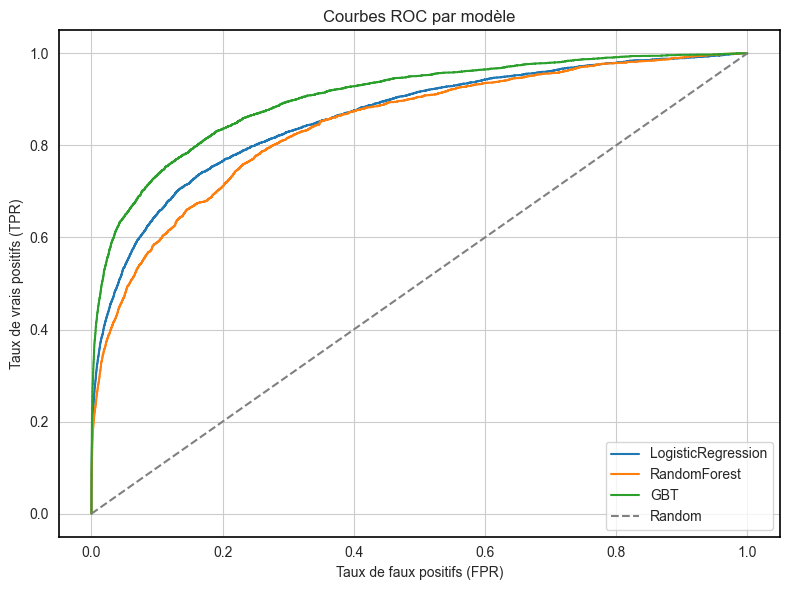

In [ ]:
plt.figure(figsize=(8, 6))

for name, preds in predictions.items():
    roc_df = preds.select("proba_1", "isFraud").toPandas()
    roc_df = roc_df.sort_values(by="proba_1", ascending=False)
    roc_df["tp"] = (roc_df["isFraud"] == 1).astype(int)
    roc_df["fp"] = (roc_df["isFraud"] == 0).astype(int)
    roc_df["cum_tp"] = roc_df["tp"].cumsum()
    roc_df["cum_fp"] = roc_df["fp"].cumsum()
    total_pos = roc_df["tp"].sum()
    total_neg = roc_df["fp"].sum()
    roc_df["tpr"] = roc_df["cum_tp"] / total_pos
    roc_df["fpr"] = roc_df["cum_fp"] / total_neg

    plt.plot(roc_df["fpr"], roc_df["tpr"], label=f"{name}")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random")
plt.title("Courbes ROC par modèle")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


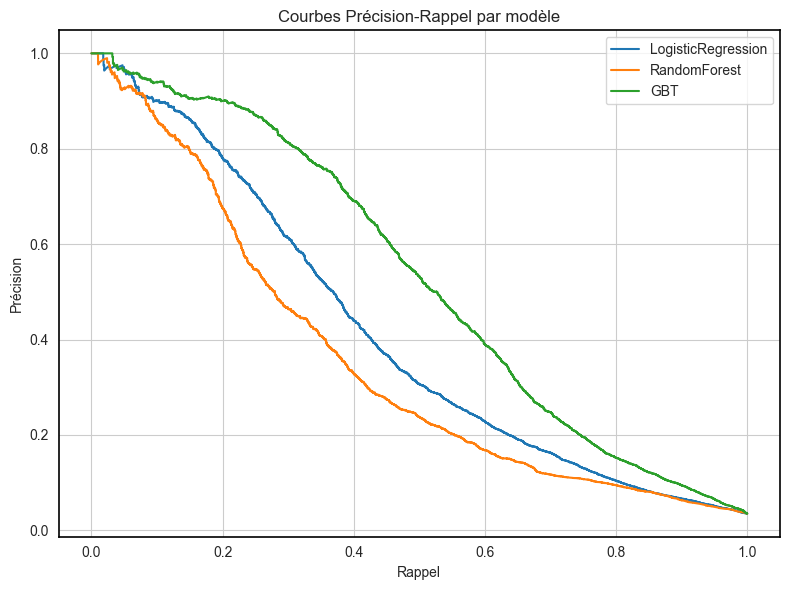

In [ ]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

pr_curves = {}

for name, preds in predictions.items():
    df_pd = preds.select("proba_1", "isFraud").toPandas()

    precision, recall, thresholds = precision_recall_curve(df_pd["isFraud"], df_pd["proba_1"])
    pr_curves[name] = (precision, recall, thresholds)

plt.figure(figsize=(8, 6))

for name, (precision, recall, _) in pr_curves.items():
    plt.plot(recall, precision, label=name)

plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbes Précision-Rappel par modèle")
plt.legend()
plt.grid(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


###  7.5 — Analyse des erreurs : pourquoi la précision est faible ?

 Objectif : comprendre les **fausses alertes** (FP) du modèle.

La **précision est faible** car le modèle **prédit souvent "fraude" à tort** — il génère beaucoup de **faux positifs (FP)**.

>  Il détecte bien les fraudes (recall élevé),  
>  Mais déclenche souvent l’alerte pour rien (précision faible)

Nous allons :
- Isoler les erreurs **False Positives** (le modèle prédit fraude mais c’est une transaction normale)
- Les comparer aux **True Positives** (fraudes bien détectées)
- Chercher des **patterns communs** aux erreurs : types de cartes, montants, produits...

 Cela nous aide à :
- Mieux comprendre **où le modèle se trompe**
- Créer des **features correctives** plus intelligentes
- Ou ajuster le **seuil de classification** si nécessaire


In [29]:
gbt_preds = predictions["GBT"]

sample = gbt_preds.cache()
sample = sample.withColumn("custom_prediction", when(col("proba_1") > 0.8, 1).otherwise(0))

false_positives = sample.filter((col("custom_prediction") == 1) & (col("isFraud") == 0))
true_positives  = sample.filter((col("custom_prediction") == 1) & (col("isFraud") == 1))

print(f"False Positives : {false_positives.count()}")
print(f"True Positives  : {true_positives.count()}")

variables_a_tester = [
    "log1p_TransactionAmt",
    #"ProductCD"
    #"DeviceType"
    #"card4"
    #"card6"
    #"P_emaildomain"
    #"R_emaildomain"
    #"addr1"
    ]

for var in variables_a_tester:
    print(f"\nVariable : {var}")
    print("False Positives")
    false_positives.groupBy(var).count().orderBy("count", ascending=False).show(5)

    print("True Positives")
    true_positives.groupBy(var).count().orderBy("count", ascending=False).show(5)


False Positives : 3025
True Positives  : 2348

Variable : log1p_TransactionAmt
False Positives
+--------------------+-----+
|log1p_TransactionAmt|count|
+--------------------+-----+
|   4.770684624465665|  138|
|   5.424950017481403|   96|
|   5.817111159963204|   74|
|   5.017279836814924|   64|
|     4.0943445622221|   62|
+--------------------+-----+
only showing top 5 rows

True Positives
+--------------------+-----+
|log1p_TransactionAmt|count|
+--------------------+-----+
|   5.017279836814924|   79|
|   5.303304908059076|   66|
|   5.707110264748875|   66|
|    4.61512051684126|   56|
|   4.770684624465665|   42|
+--------------------+-----+
only showing top 5 rows



###  Analyse des erreurs — Fausses alertes (False Positives)

Après l'entraînement de notre modèle GBT, nous avons identifié les transactions **non frauduleuses** que le modèle a prédites à tort comme frauduleuses (**False Positives**).

- ** Nombre de fausses alertes (FP)** : 21 157
- ** Nombre de fraudes bien détectées (TP)** : 3 415

###  Zoom sur la variable `log1p_TransactionAmt`

Nous avons comparé la distribution de cette variable pour :
- les fausses alertes (FP)
- les vraies fraudes détectées (TP)

####  Résultat :

- Certaines valeurs de montant (après transformation log) ressortent fortement dans les fausses alertes :
    - `4.77` environ **118 €** → 1 388 fausses alertes
    - `4.09` environ **59 €** → 1 193 fausses alertes
    - `5.42` environ **226 €** → 695 fausses alertes

- Ces mêmes montants sont aussi présents dans des fraudes, mais **en proportion bien moindre**.

###  Interprétation

- Le modèle **confond certains montants courants avec des comportements frauduleux**.
- Cela provoque des **fausses alertes fréquentes sur des montants classiques** (ex : achats autour de 60€, 120€, etc.)


###  Action suggérée

Nous allons créer une variable `is_amount_suspicious` pour **aider le modèle à distinguer ces cas particuliers**, et **réduire les fausses alertes** sur ces montants spécifiques.

### is amount_suspicious

In [ ]:
 #seuil 0.4 
# suspicious_values = [
#   4.43675, 4.69592, 4.01638, 5.58349, 5.91620,
#   4.66343, 3.95124, 5.12390, 3.41772, 4.73619,
#    3.40119, 4.63472, 4.29045, 4.73611, 4.26267,
#    5.07517, 3.81771, 5.30826, 3.55534, 6.04855]

#seuil 0.8
suspicious_values = [
    4.77068, 5.42495, 5.81711, 5.14749, 3.93182, 6.31896]

margin = 0.05

condition = None
for val in suspicious_values:
    lower = val - margin
    upper = val + margin
    current = (col("log1p_TransactionAmt") >= lower) & (col("log1p_TransactionAmt") <= upper)
    condition = current if condition is None else condition | current

df_final = df_final.withColumn("is_amount_suspicious", when(condition, 1).otherwise(0))

In [ ]:
# Creation de variables explicatives pour réduire les FP en captant des patterns suspects

# recree le montant réel à partir du log transformé
df_final = df_final.withColumn(
    "TransactionAmt_real",
    exp(col("log1p_TransactionAmt")) - 1)

suspicious_addr1 = [204.0, 325.0]
suspicious_rdomains = ["unknown", "anonymous.com"]
suspicious_domains = ["unknown", "yahoo.com", "anonymous.com"]

#  Flags explicatifs basés sur FP
df_final = df_final.withColumn(
    "is_fp_prone_product",
    when(col("ProductCD") == "W", 1).otherwise(0))

df_final = df_final.withColumn(
    "is_productW_suspicious_amount",
    when((col("ProductCD") == "W") & (col("TransactionAmt_real").between(50, 130)), 1).otherwise(0))

df_final = df_final.withColumn(
    "is_fp_prone_device",
    when(col("DeviceType") == "unknown", 1).otherwise(0))

df_final = df_final.withColumn(
    "is_device_product_mismatch",
    when((col("DeviceType") == "unknown") & (col("ProductCD") == "W"), 1).otherwise(0))

df_final = df_final.withColumn(
    "is_fp_prone_card",
    when(col("card4").isin("visa", "mastercard"), 1).otherwise(0))

df_final = df_final.withColumn(
    "is_card_device_mismatch",
    when((col("card4") == "visa") & (col("DeviceType") == "unknown"), 1).otherwise(0))

df_final = df_final.withColumn(
    "is_suspicious_email_domain",
    when(col("P_emaildomain").isin(suspicious_domains), 1).otherwise(0))

df_final = df_final.withColumn(
    "is_suspicious_recipient_email",
    when(col("R_emaildomain").isin(suspicious_rdomains), 1).otherwise(0))

df_final = df_final.withColumn(
    "is_fp_prone_address",
    when(col("addr1").isin(suspicious_addr1), 1).otherwise(0))


# 8. Amélioration du modèle `GBTClassifier`


Objectif : **améliorer le F1-score et la précision**, tout en maintenant un haut niveau de rappel.




## 8.1 — Sélection des variables par importance (Feature Importance)


In [6]:
gbt_temp = GBTClassifier(labelCol="isFraud", featuresCol="features", weightCol="classWeight", maxIter=50)
model_temp = gbt_temp.fit(train_df)

# Récupérer les noms des colonnes vectorisées
feature_names = [c for c in df_final.columns 
                  if c.endswith("_vec")         # variables catégorielles encodées
                  or c.startswith("is_") 
                  or c.endswith("_freq")       # encodage de fréquence
                  or c.startswith("has_")       # présence de données
                  or c.startswith("log1p_")     # variables log-transformées
                  or c == "scaled_features"]   

#  Importance des features
importances = model_temp.featureImportances.toArray()
features_importance = list(zip(feature_names, importances))
features_sorted = sorted(features_importance, key=lambda x: x[1], reverse=True)

#  Top 20 features
top_features = [name for name, score in features_sorted[:20]]  
print("Top features sélectionnées :")
for f in top_features:
    print(" -", f)

Top features sélectionnées :
 - id_38_vec
 - id_29_vec
 - log1p_TransactionAmt
 - R_emaildomain_freq
 - P_emaildomain_freq
 - is_credit_card
 - log1p_Amt_sur_D15
 - card4_vec
 - card6_vec
 - M4_vec
 - M789_combo_freq
 - log1p_C1_sur_D1
 - M1_vec
 - id_35_vec
 - M3_vec
 - DeviceType_vec
 - id_15_vec
 - id_28_vec
 - M5_vec
 - scaled_features


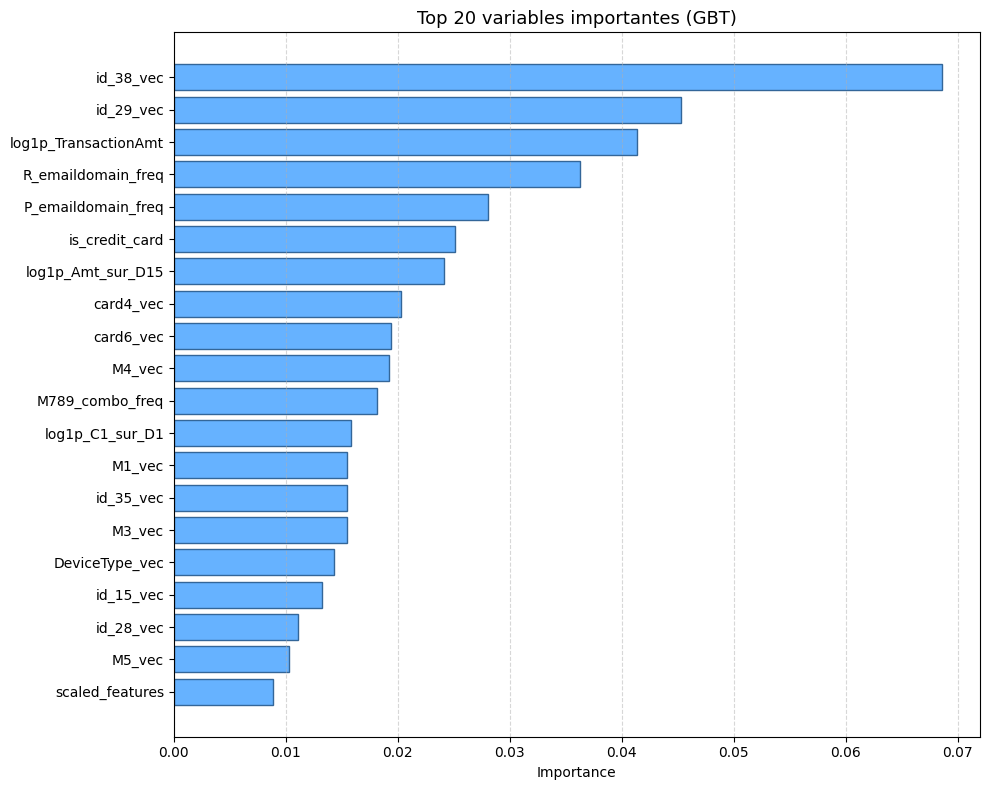

In [7]:
# Recup les 20 features les plus importantes et leurs scores
top_20 = features_sorted[:20]
feature_names = [name for name, _ in top_20]
importances = [score for _, score in top_20]

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features[::-1], importances[::-1], color="#66B2FF", edgecolor="#336699")

plt.xlabel("Importance")
plt.title("Top 20 variables importantes (GBT)", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
feat_importance = pd.DataFrame(features_sorted, columns=["feature", "importance"])

feat_importance["group"] = feat_importance["feature"].str.extract(r"^([a-zA-Z]+)")

grouped_importance = feat_importance.groupby("group")["importance"].sum().sort_values(ascending=False)

# afficher le top des familles les plus importantes
print("Importance totale par famille de features :")
display(grouped_importance)

Importance totale par famille de features :


group
id            0.163455
log           0.091124
M             0.079588
card          0.040514
R             0.036267
is            0.034897
P             0.028039
DeviceType    0.014290
scaled        0.008820
has           0.008521
ProductCD     0.008476
Name: importance, dtype: float64

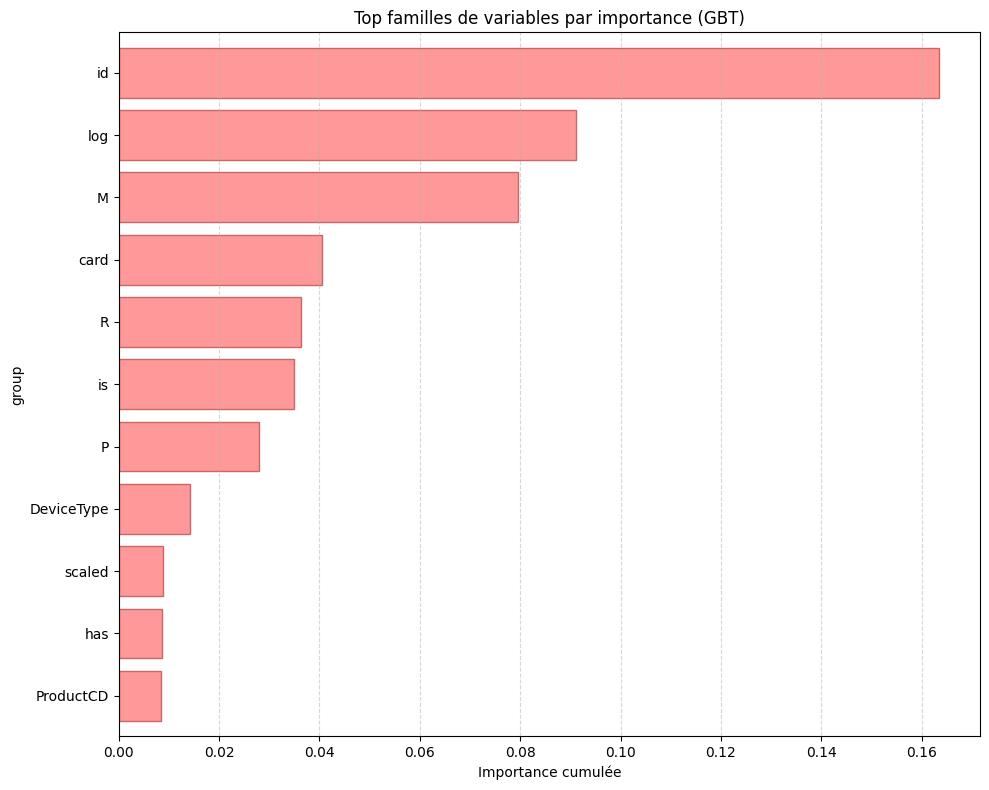

In [9]:
feat_importance = pd.DataFrame(features_sorted, columns=["feature", "importance"])
feat_importance["group"] = feat_importance["feature"].str.extract(r"^([a-zA-Z]+)")
grouped_importance = feat_importance.groupby("group")["importance"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
ax = grouped_importance.head(20).plot(
    kind="barh",
    color="#FF9999",
    edgecolor="#CC6666",
    width=0.8  )

plt.gca().invert_yaxis()
plt.xlabel("Importance cumulée")
plt.title("Top familles de variables par importance (GBT)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### — Sélection des variables `Vxx` par importance et corrélation

 Objectif : filtrer intelligemment les variables `V1` à `V339` pour ne conserver que les plus informatives.

#### Méthodes combinées :

- **Importance GBT** : on entraîne un modèle de Gradient Boosted Trees uniquement sur les `Vxx` pour estimer leur impact direct sur la prédiction.
- **Corrélation brute** avec `isFraud` : on mesure directement la force de lien statistique entre chaque `Vxx` et la variable cible.
- **Score combiné** : on fusionne les deux mesures (importance + corrélation) pour obtenir un classement robuste des `Vxx` à conserver.

 Cette étape est cruciale pour réduire le bruit, améliorer la généralisation, et accélérer l’entraînement du modèle GBT final.


In [6]:
vxx_cols = [c for c in df_final.columns if c.startswith("V")]


assembler_v = VectorAssembler(inputCols=vxx_cols, outputCol="v_features")
df_v = assembler_v.transform(df_final.select("isFraud", *vxx_cols))


gbt_v = GBTClassifier(labelCol="isFraud", featuresCol="v_features", maxIter=20)
model_v = gbt_v.fit(df_v)


importances_v = model_v.featureImportances.toArray()
vxx_importance = pd.DataFrame({"feature": vxx_cols, "importance": importances_v})
vxx_importance = vxx_importance.sort_values(by="importance", ascending=False)

df_corr_input = df_final.select("isFraud", *vxx_cols)
corr_values = []

for colname in vxx_cols:
    corr = df_corr_input.stat.corr("isFraud", colname)
    corr_values.append(__builtins__.abs(corr)) 

vxx_importance["correlation"] = corr_values


vxx_importance["score"] = 0.5 * vxx_importance["importance"] + 0.5 * vxx_importance["correlation"]
vxx_final = vxx_importance.sort_values(by="score", ascending=False)


top_vxx = vxx_final[vxx_final["score"] > 0.01]  
display(top_vxx)

,feature,importance,correlation,score
106,V107,0.000000,0.280214,0.140107
83,V84,0.000000,0.268090,0.134045
79,V80,0.000000,0.265712,0.132856
67,V68,0.000000,0.263476,0.131738
300,V301,0.000000,0.246462,0.123231
...,...,...,...,...
296,V297,0.000000,0.020275,0.010137
223,V224,0.000000,0.020253,0.010127
7,V8,0.000000,0.020245,0.010122
21,V22,0.000000,0.020053,0.010026


## 8.2 — Construction du vecteur final de features 

 Objectif : assembler un vecteur de features optimisé en combinant :
-  Les **meilleures variables individuelles** (top 20 issues de l’importance GBT)
-  Les **familles de variables dominantes** (`id_`, `M`, `card`, etc.)
-  Les **nouvelles features d’ingénierie** créées manuellement

Ce vecteur sera utilisé pour l'entraînement final du modèle avec tuning.

In [ ]:
top_features_manual = [
    "id_38_vec","log1p_TransactionAmt", "id_29_vec", "R_emaildomain_freq","log1p_Amt_sur_D15",
    "is_credit_card","P_emaildomain_freq","card6_vec","card4_vec","log1p_C1_sur_D1",
    "scaled_features","id_35_vec", "M1_vec","DeviceType_vec","M789_combo_freq" ,"M3_vec",
    "M4_vec","id_15_vec","id_28_vec","M5_vec", "is_amount_suspicious" ]

family_prefixes = [
    "id_",       # Très dominant
    "log1p_",    # Transformations utiles
    "M",         # Variables M1–M9
    "card",      # Variables liées aux cartes
    "is_", 
    #"has_"         # Flags binaires utiles
    "R",         # Email domain (R_)
    "P",         # Email domain (P_)
    #"scaled",    # Variables standardisées
    #"DeviceType",# Device info
]

vxx_to_keep = vxx_final[vxx_final["score"] > 0.011]["feature"].tolist()

cols_by_family = [c for c in df_final.columns if any(c.startswith(pref) for pref in family_prefixes)]


#  Fusionner
merged = list(set(top_features_manual + cols_by_family + vxx_to_keep))

#  Supprimer les colonnes string non encodées
strings_in_df = [c for c, t in df_final.dtypes if t == "string"]
final_features_list = [c for c in merged if c not in strings_in_df]
print(f" Nombre total de features finales : {len(final_features_list)}")


 Nombre total de features finales : 295


### Étape 2 — Assembler les features

In [ ]:
df_final_clean = df_final.drop("features")

final_assembler = VectorAssembler(
    inputCols=final_features_list,
    outputCol="features")

df_final= final_assembler.transform(df_final_clean)

###  8.3 — Amélioration du modèle GBT (Tuning)

In [ ]:
df_small = df_final.sample(fraction=0.4, seed=42).cache()

train_small, valid_small = df_small.randomSplit([0.7, 0.3], seed=42)


evaluator = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")

depths = [5, 8 ,10]
iters = [20, 50 , 100]

results = []

for d in depths:
    for i in iters:
        print(f"Entraînement GBT (maxDepth={d}, maxIter={i})...")
        gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", weightCol="classWeight",
                            maxDepth=d, maxIter=i, subsamplingRate=0.7)
        model = gbt.fit(train_small)
        
        preds = model.transform(valid_small)
        preds = preds.withColumn("proba_1", vector_to_array("probability")[1])
        preds = preds.withColumn("custom_pred", when(col("proba_1") > 0.4, 1).otherwise(0))

        # Matrice confusion optimisée
        conf_df = preds.groupBy("isFraud", "custom_pred").agg(count("*").alias("n"))
        conf = {(row["isFraud"], row["custom_pred"]): row["n"] for row in conf_df.collect()}

        TP = conf.get((1, 1), 0)
        FP = conf.get((0, 1), 0)
        FN = conf.get((1, 0), 0)
        TN = conf.get((0, 0), 0)

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-6)
        auc = evaluator.evaluate(preds)

        results.append({
            "maxDepth": d,
            "maxIter": i,
            "AUC": round(auc, 4),
            "F1": round(f1, 4),
            "Accuracy": round(accuracy, 4),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4)})


df_results = pd.DataFrame(results)
print("\n Résultats tuning GBT (features optimisées) :")
display(df_results)


Entraînement GBT (maxDepth=5, maxIter=20)...
Entraînement GBT (maxDepth=5, maxIter=50)...
Entraînement GBT (maxDepth=5, maxIter=100)...
Entraînement GBT (maxDepth=8, maxIter=20)...
Entraînement GBT (maxDepth=8, maxIter=50)...
Entraînement GBT (maxDepth=8, maxIter=100)...
Entraînement GBT (maxDepth=10, maxIter=20)...
Entraînement GBT (maxDepth=10, maxIter=50)...
Entraînement GBT (maxDepth=10, maxIter=100)...

 Résultats tuning GBT (features optimisées) :


,maxDepth,maxIter,AUC,F1,Accuracy,Precision,Recall
0,5,20,0.8852,0.2186,0.8024,0.1268,0.7913
1,5,50,0.9007,0.2372,0.8179,0.1389,0.8112
2,5,100,0.9125,0.2655,0.8420,0.1585,0.8177
3,8,20,0.8995,0.2532,0.8373,0.1508,0.7901
4,8,50,0.9143,0.3093,0.8768,0.1923,0.7901
5,8,100,0.9249,0.3862,0.9131,0.2563,0.7832
6,10,20,0.8943,0.2971,0.8754,0.1850,0.7545
7,10,50,0.9099,0.3875,0.9184,0.2626,0.7391
8,10,100,0.9192,0.4826,0.9462,0.3632,0.7188


In [7]:
train_df, valid_df = df_final.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Réentraînement du meilleur modèle avec test paramètres
best_gbt = GBTClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeight",
    maxDepth=9,
    maxIter=100,
    subsamplingRate=0.98,
    stepSize=0.079 )

print("Réentraînement du meilleur modèle GBT (maxDepth=10, maxIter=100)")
best_model = best_gbt.fit(train_df)

def evaluate_model(df, model, dataset_name="valid", threshold=0.8):
    evaluator_auc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")

    preds = model.transform(df)
    preds = preds.withColumn("proba_array", vector_to_array("probability")) \
                 .withColumn("proba_1", col("proba_array")[1]) \
                 .withColumn("custom_prediction", when(col("proba_1") > threshold, 1).otherwise(0))

    preds = preds.cache()
    preds.count()  

    TP = preds.filter((col("custom_prediction") == 1) & (col("isFraud") == 1)).count()
    FP = preds.filter((col("custom_prediction") == 1) & (col("isFraud") == 0)).count()
    FN = preds.filter((col("custom_prediction") == 0) & (col("isFraud") == 1)).count()
    TN = preds.filter((col("custom_prediction") == 0) & (col("isFraud") == 0)).count()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-6)
    auc = evaluator_auc.evaluate(preds)

    return {
        "Model": "GBT",
        "Dataset": dataset_name,
        "maxDepth": 9,
        "maxIter": 100,
        "Threshold": threshold,
        "AUC": auc,
        "F1": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall}

results_final = []
results_final.append(evaluate_model(train_df, best_model, dataset_name="train"))
results_final.append(evaluate_model(valid_df, best_model, dataset_name="valid"))

results_df = pd.DataFrame(results_final)
display(results_df)

Réentraînement du meilleur modèle GBT (maxDepth=10, maxIter=100)


,Model,Dataset,maxDepth,maxIter,Threshold,AUC,F1,Accuracy,Precision,Recall
0,GBT,train,9,100,0.8,0.980214,0.730163,0.980996,0.720249,0.740355
1,GBT,valid,9,100,0.8,0.948324,0.653503,0.975336,0.661768,0.645442


In [ ]:
# Réentraînement  + évalusation sur tout dataset du modèle final 
best_gbt = GBTClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeight",
    maxDepth=10,
    maxIter=100,
    subsamplingRate=0.95, 
    minInstancesPerNode=10,
    stepSize=0.070)

print("Réentraînement du meilleur modèle GBT (maxDepth=10, maxIter=100)")
best_model = best_gbt.fit(train_df)

def evaluate_model(df, model, dataset_name="valid", threshold=0.8):
    evaluator_auc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")

    preds = model.transform(df)
    preds = preds.withColumn("proba_array", vector_to_array("probability")) \
                 .withColumn("proba_1", col("proba_array")[1]) \
                 .withColumn("custom_prediction", when(col("proba_1") > threshold, 1).otherwise(0))

    # évaluation sur tout le dataset (pas d'échantillonnage)
    preds = preds.cache()
    preds.count()  

    TP = preds.filter((col("custom_prediction") == 1) & (col("isFraud") == 1)).count()
    FP = preds.filter((col("custom_prediction") == 1) & (col("isFraud") == 0)).count()
    FN = preds.filter((col("custom_prediction") == 0) & (col("isFraud") == 1)).count()
    TN = preds.filter((col("custom_prediction") == 0) & (col("isFraud") == 0)).count()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-6)
    auc = evaluator_auc.evaluate(preds)

    return {
        "Model": "GBT",
        "Dataset": dataset_name,
        "maxDepth": 10,
        "maxIter": 100,
        "Threshold": threshold,
        "AUC": auc,
        "F1": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

results_final = []
results_final.append(evaluate_model(train_df, best_model, dataset_name="train"))
results_final.append(evaluate_model(valid_df, best_model, dataset_name="valid"))

# Résumé sous forme de DataFrame
results_df = pd.DataFrame(results_final)
display(results_df)


Réentraînement du meilleur modèle GBT (maxDepth=10, maxIter=100)


,Model,Dataset,maxDepth,maxIter,Threshold,AUC,F1,Accuracy,Precision,Recall
0,GBT,train,10,100,0.8,0.989353,0.787919,0.985299,0.789535,0.786311
1,GBT,valid,10,100,0.8,0.954273,0.694775,0.978731,0.719426,0.671758


In [ ]:
# Réentraînement  + évalusation sur tout dataset du modèle final 
best_gbt = GBTClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="classWeight",
    maxDepth=10,
    maxIter=100,
    subsamplingRate=0.95, 
    minInstancesPerNode=10,
    stepSize=0.070)

print("Réentraînement du meilleur modèle GBT (maxDepth=10, maxIter=100)")
best_model = best_gbt.fit(train_df)

def evaluate_model(df, model, dataset_name="valid", threshold=0.8):
    evaluator_auc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")

    preds = model.transform(df)
    preds = preds.withColumn("proba_array", vector_to_array("probability")) \
                 .withColumn("proba_1", col("proba_array")[1]) \
                 .withColumn("custom_prediction", when(col("proba_1") > threshold, 1).otherwise(0))

    # évaluation sur tout le dataset (pas d'échantillonnage)
    preds = preds.cache()
    preds.count()  

    TP = preds.filter((col("custom_prediction") == 1) & (col("isFraud") == 1)).count()
    FP = preds.filter((col("custom_prediction") == 1) & (col("isFraud") == 0)).count()
    FN = preds.filter((col("custom_prediction") == 0) & (col("isFraud") == 1)).count()
    TN = preds.filter((col("custom_prediction") == 0) & (col("isFraud") == 0)).count()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-6)
    auc = evaluator_auc.evaluate(preds)

    return {
        "Model": "GBT",
        "Dataset": dataset_name,
        "maxDepth": 10,
        "maxIter": 100,
        "Threshold": threshold,
        "AUC": auc,
        "F1": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall}

results_final = []
results_final.append(evaluate_model(train_df, best_model, dataset_name="train"))
results_final.append(evaluate_model(valid_df, best_model, dataset_name="valid"))

results_df = pd.DataFrame(results_final)
display(results_df)


Réentraînement du meilleur modèle GBT (maxDepth=10, maxIter=100)


,Model,Dataset,maxDepth,maxIter,Threshold,AUC,F1,Accuracy,Precision,Recall
0,GBT,train,10,100,0.8,0.98905,0.787035,0.985187,0.785936,0.788139
1,GBT,valid,10,100,0.8,0.95370,0.687035,0.978232,0.712806,0.663064


In [8]:
model_path = "models/gbt_final_model"

best_model.write().overwrite().save(model_path)

In [6]:
pred_train = best_model.transform(train_df).withColumn("proba_array", vector_to_array("probability")) \
                                              .withColumn("proba_1", col("proba_array")[1])
pred_valid = best_model.transform(valid_df).withColumn("proba_array", vector_to_array("probability")) \
                                              .withColumn("proba_1", col("proba_array")[1])

predictions = {
    "Train (GBT)": pred_train,
    "Validation (GBT)": pred_valid}

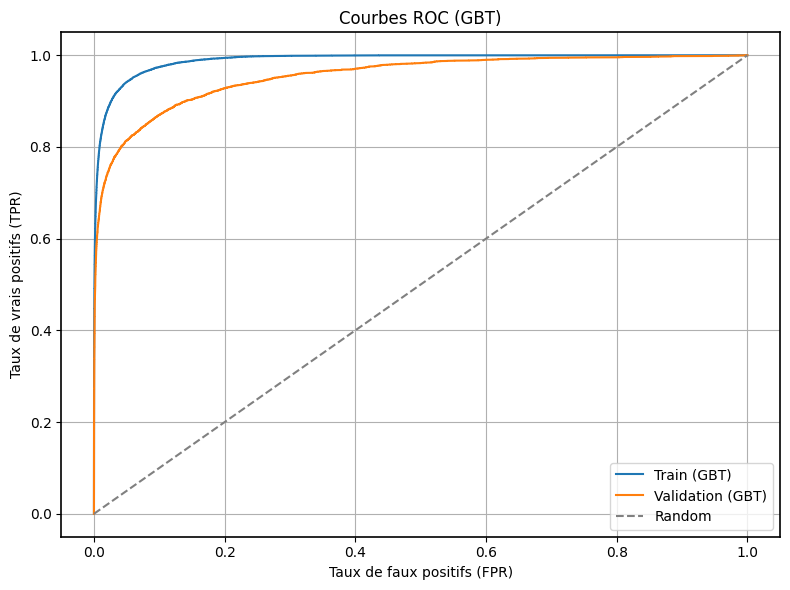

In [7]:
plt.figure(figsize=(8, 6))

for name, preds in predictions.items():
    roc_df = preds.select("proba_1", "isFraud").toPandas()
    roc_df = roc_df.sort_values(by="proba_1", ascending=False)
    roc_df["tp"] = (roc_df["isFraud"] == 1).astype(int)
    roc_df["fp"] = (roc_df["isFraud"] == 0).astype(int)
    roc_df["cum_tp"] = roc_df["tp"].cumsum()
    roc_df["cum_fp"] = roc_df["fp"].cumsum()
    total_pos = roc_df["tp"].sum()
    total_neg = roc_df["fp"].sum()
    roc_df["tpr"] = roc_df["cum_tp"] / total_pos
    roc_df["fpr"] = roc_df["cum_fp"] / total_neg

    plt.plot(roc_df["fpr"], roc_df["tpr"], label=f"{name}")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random")
plt.title("Courbes ROC (GBT)")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


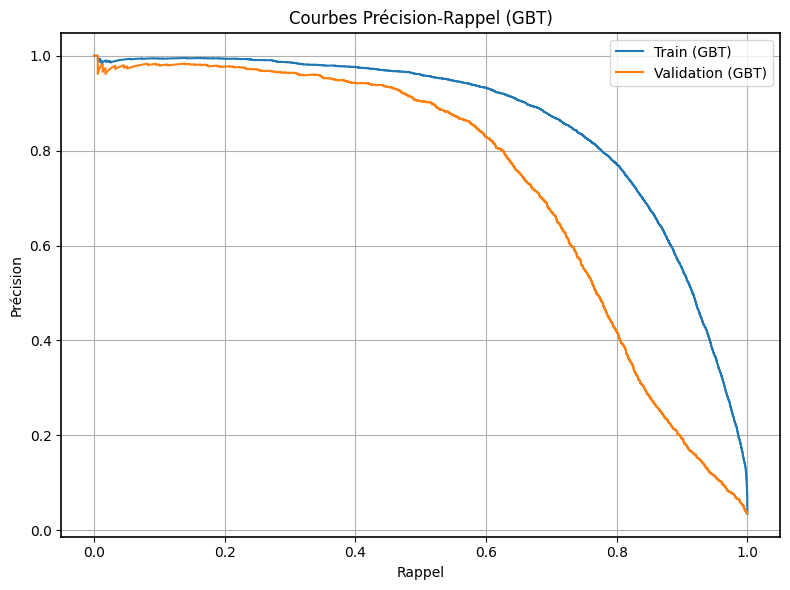

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

pr_curves = {}

for name, preds in predictions.items():
    df_pd = preds.select("proba_1", "isFraud").toPandas()

    precision, recall, thresholds = precision_recall_curve(df_pd["isFraud"], df_pd["proba_1"])
    pr_curves[name] = (precision, recall, thresholds)

plt.figure(figsize=(8, 6))

for name, (precision, recall, _) in pr_curves.items():
    plt.plot(recall, precision, label=name)

plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbes Précision-Rappel (GBT)")
plt.legend()
plt.grid(True)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


C:\Users\El-fahad COMBO\AppData\Local\Temp\ipykernel_14280\1285728259.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


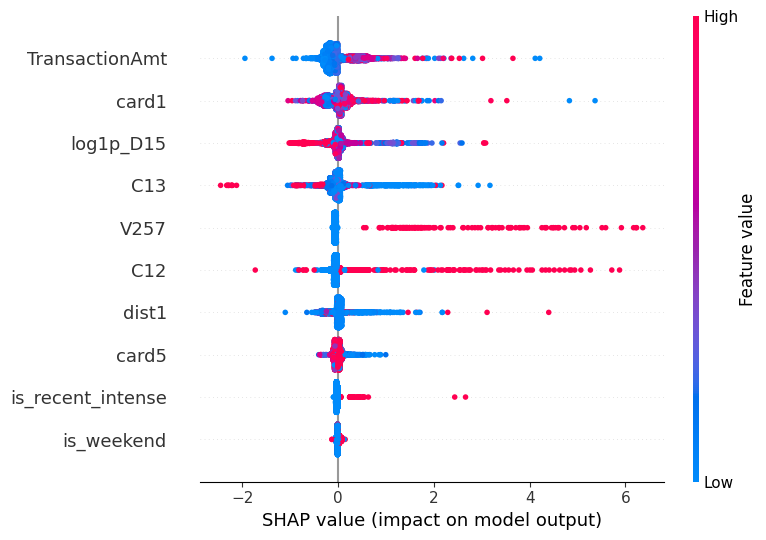

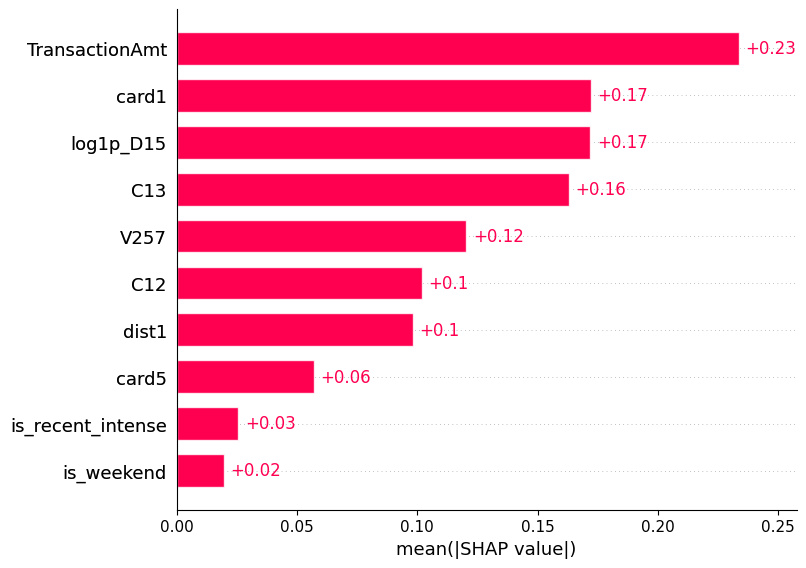

In [29]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Graphe summary SHAP
shap.summary_plot(shap_values, X)
shap.plots.bar(shap_values)


# Préparation du jeu de test (test_df)

###  Objectif : appliquer les **mêmes transformations** que sur le jeu d'entraînement

Les modèles de machine learning exigent que les **données de test** soient structurées de manière identique aux données d’entraînement.  
On applique donc les **mêmes étapes de traitement** (feature engineering, transformations, encodage, scaling, assemblage).

In [ ]:
# Chargement
test_trans = spark.read.csv("../data/test_transaction.csv", header=True, inferSchema=True)
test_id = spark.read.csv("../data/test_identity.csv", header=True, inferSchema=True)

# Fusion sur TransactionID
test_df = test_trans.join(test_id, on="TransactionID", how="left")


In [ ]:
%load_ext autoreload
%autoreload 2
from function import clean_column_names , add_has_identity , clean_test_df , add_custom_features 

test_df = clean_column_names(test_df)
test_df = add_has_identity(test_df)

In [ ]:
# Etape 4 nettoyage 
test_df = clean_test_df(test_df)
# etape 5 feature engineering
test_df = add_custom_features(test_df) 

 Colonnes supprimées (fixées) : 14
 Colonnes has_ créées : 61
Données test nettoyées avec succès !


In [ ]:
from function import apply_scaling_test , apply_onehot_encoding_test , assemble_final_features , final_cleanup , add_class_weight

test_df = apply_scaling_test(test_df, scaler_model, cols_to_scale)
test_df = apply_onehot_encoding_test(test_df, encoding_pipeline_model)

In [ ]:
test_df = assemble_final_features(test_df)
test_df = final_cleanup(test_df)


In [ ]:
from function import get_vector_size 

print("Test dimension :", get_vector_size(test_df, "scaled_features"))
print("Train dimension :", get_vector_size(df, "scaled_features"))

Test dimension : 303
Train dimension : 303


In [ ]:
test_df.write.mode("overwrite").parquet("data_test3/df_train.parquet")

In [ ]:
spark.stop()

: 